In [1]:
# import matplotlib
# matplotlib.matplotlib_fname()

In [2]:
import os
import os.path as osp
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from mplfonts import use_font
from optuna.trial import TrialState


use_font('Noto Serif CJK SC')  #指定中文字体
# 设置matplotlib字体，使之显示中文
# plt.rcParams["font.sans-serif"] = ["SIMSUN"]
# plt.rcParams["axes.unicode_minus"] = False
# plt.rcParams["text.usetex"] = False
# plt.rcParams['mathtext.fontset'] = 'stix'
# Customize matplotlib
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': False,
#                             # Use the Computer modern font
#                             # 'font.family': 'serif',
#                             # 'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             # Use ASCII minus
#                             'axes.unicode_minus': False,
#                             })

exchange_rate = 6.8967

/home/luyiyun/miniconda3/envs/tdm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
d_results = {
    "情景1": ("./results/backup3/opt_res_m30_nodisc/", "./results/backup4/opt_res_m30_disc/"),
    "情景2": ("./results/backup3/opt_res_m40_nodisc/", "./results/backup4/opt_res_m40_disc/"),
    "情景3": ("./results/backup3/opt_res_m50_nodisc/", "./results/backup4/opt_res_m50_disc/"),
    "情景4": ("./results/backup3/opt_res_m60_nodisc/", "./results/backup4/opt_res_m60_disc/"),
    "情景5": ("./results/backup3/opt_res_m80_nodisc/", "./results/backup4/opt_res_m80_disc/"),
    "情景6": ("./results/backup3/opt_res_m100_nodisc/", "./results/backup4/opt_res_m100_disc/"),
}
d_duration = {
    "情景1": "30",
    "情景2": "40",
    "情景3": "50",
    "情景4": "60",
    "情景5": "80",
    "情景6": "100",
}

我们先把一些要用的数据载入：

In [4]:
# 跑程序得到的结果
d_evals = {}
for k, (nodi_root, disc_root) in d_results.items():
    with open(osp.join(nodi_root, "tar_eval.pkl"), "rb") as f:
        nodi_tar_eval = pickle.load(f)
    with open(osp.join(nodi_root, "ref_eval.pkl"), "rb") as f:
        nodi_ref_eval = pickle.load(f)
    with open(osp.join(disc_root, "tar_eval.pkl"), "rb") as f:
        disc_tar_eval = pickle.load(f)
    with open(osp.join(disc_root, "ref_eval.pkl"), "rb") as f:
        disc_ref_eval = pickle.load(f)
    
    d_evals[k] = {"nodisc": (nodi_tar_eval, nodi_ref_eval), "disc": (disc_tar_eval, disc_ref_eval)}

In [5]:
# 把所有的试验结果都载入
d_trials, d_best_trials, d_choice_trial = {}, {}, {}
ori_cwd = "/home/luyiyun/Documents/hpv_tdm"
os.chdir(ori_cwd)
for k, (nodisc_root, disc_root) in d_results.items():
    d_trials_i, d_best_trials_i, d_choice_trial_i = [], [], []
    for tar_root in [nodisc_root, disc_root]:
        os.chdir(tar_root)
        study_name = "HPV_tdm"
        storage_name = "sqlite:///{}.db".format(study_name)
        with open("sampler.pkl", "rb") as f:
            sampler = pickle.load(f)
        study = optuna.create_study(study_name=study_name,
                                    storage=storage_name,
                                    sampler=sampler,
                                    directions=["minimize", "minimize"],
                                    load_if_exists=True)
        # 所有的trials
        trials = study.get_trials(states=(TrialState.COMPLETE,))
        d_trials_i.append(trials)
        # 所有的best trials
        d_best_trials_i.append(study.best_trials)
        # 找到那个我们选择的策略
        best_icer, choice_trial = np.inf, None
        for trial in study.best_trials:
            if trial.values[0] < best_icer and trial.values[1] <= 4e-5:
                best_icer = trial.values[0]
                choice_trial = trial
        d_choice_trial_i.append(choice_trial)
        os.chdir(ori_cwd)
    d_trials[k] = d_trials_i
    d_best_trials[k] = d_best_trials_i
    d_choice_trial[k] = d_choice_trial_i
    os.chdir(ori_cwd)

for k in d_results.keys():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        print("%s, %s: num of trials is %d, num of best trials is %d." % (k, disc_flag, len(d_trials[k][i]), len(d_best_trials[k][i])))

[I 2023-03-10 13:40:15,286] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:15,510] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:15,748] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:15,985] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:16,225] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:16,468] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:16,633] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:16,878] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:17,137] Using an existing study with name 'HPV_tdm' instead of creating a new one.
[I 2023-03-10 13:40:17,393] Using an existing study with name 'HPV_tdm' i

情景1, nodisc: num of trials is 500, num of best trials is 194.
情景1, disc: num of trials is 500, num of best trials is 193.
情景2, nodisc: num of trials is 500, num of best trials is 225.
情景2, disc: num of trials is 500, num of best trials is 201.
情景3, nodisc: num of trials is 500, num of best trials is 260.
情景3, disc: num of trials is 500, num of best trials is 273.
情景4, nodisc: num of trials is 500, num of best trials is 278.
情景4, disc: num of trials is 500, num of best trials is 308.
情景5, nodisc: num of trials is 500, num of best trials is 239.
情景5, disc: num of trials is 500, num of best trials is 307.
情景6, nodisc: num of trials is 500, num of best trials is 204.
情景6, disc: num of trials is 500, num of best trials is 320.


# 优化过程

## Table(优化结果)

In [5]:
df_table = []
for k in d_results.keys():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        best_trial = d_choice_trial[k][i]
        params = best_trial.params
        
        eval_i = d_evals[k][disc_flag][0]
        model = eval_i.model
        if "target_age_span" in params:
            start, end = params["target_age_span"]
            target_age = list(range(start, end+1))
        elif "target_age" in params:
            target_age_wild = params["target_age"]
            if isinstance(target_age_wild, int):
                target_age = [target_age_wild]
            elif isinstance(target_age_wild, (tuple, list)):
                target_age = list(target_age_wild)
            else:
                raise ValueError
        target_age_str = [model.agebin_names[i] for i in target_age]

        if "coverage" in params:
            cover = [params["coverage"]]
        else:
            cover = [params["coverage%d" % i] for i in target_age]
    
        target_vacc = params["target_vacc"]
        target_vacc = {"dom2": "国产2价", "imp2": "进口2价", "imp9": "进口9价"}[target_vacc]
    
        resi = {
            "名称": k,
            "实施时长": d_duration[k],
            "目标年龄组": ",".join(target_age_str),
            "疫苗价型": target_vacc,
            "覆盖率": ",".join(["%.2f%%" % (coveri * 100) for coveri in cover]),
            "ICUR": eval_i.icur_[-1]*exchange_rate if disc_flag == "nodisc" else eval_i.icur_disc_[-1] * exchange_rate,
            "discount": disc_flag
        }
        df_table.append(resi)
    
df_table = pd.DataFrame.from_records(df_table)

In [6]:
df_table1 = df_table.melt(id_vars=["名称", "discount"], var_name="var", value_name="value").pivot(index="名称", columns=["var", "discount"], values="value")
df_table1.round(2)

var        实施时长          目标年龄组             疫苗价型           覆盖率          \
discount nodisc disc    nodisc      disc nodisc  disc  nodisc    disc   
名称                                                                      
情景1          30   30  [15, 18)  [15, 18)   国产2价  国产2价  45.27%  44.92%   
情景2          40   40  [13, 14)  [13, 14)   国产2价  国产2价  70.40%  67.82%   
情景3          50   50  [13, 14)  [13, 14)   国产2价  国产2价  40.17%  39.83%   
情景4          60   60  [13, 14)  [13, 14)   国产2价  国产2价  29.35%  29.48%   
情景5          80   80  [13, 14)  [13, 14)   国产2价  国产2价  21.38%  20.44%   
情景6         100  100  [13, 14)  [13, 14)   国产2价  国产2价  16.45%  16.46%   

var               ICUR                
discount        nodisc          disc  
名称                                    
情景1       45864.049049  71320.848062  
情景2       -2657.359782   9910.041337  
情景3      -12546.926549  -4593.764503  
情景4       -14898.81836  -9548.456053  
情景5      -14815.385966 -12343.890728  
情景6      -14174.830177 -12925.426453

In [7]:
df_table1.round(2).to_excel("./results/table1.xlsx")

## Figure(优化历史)

In [5]:
df_hist = []
for k, trials2 in d_trials.items():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        trials = trials2[i]
        dfi = []
        min_value = np.inf
        for trial in trials:
            value = {"Trial": trial.number, "ICUR": trial.values[0]}
            if value["ICUR"] < min_value:
                min_value = value["ICUR"]
                value["is_best"] = True
            else:
                value["is_best"] = False

            dfi.append(value)
        dfi = pd.DataFrame.from_records(dfi)
        dfi["strategy"] = d_duration[k]
        dfi["discount"] = disc_flag
        df_hist.append(dfi)
df_hist = pd.concat(df_hist)
df_hist["ICUR"] = df_hist["ICUR"] * exchange_rate
df_hist.head()

,Trial,ICUR,is_best,strategy,discount
0,0,25140.263898,True,30,nodisc
1,1,315411.266723,False,30,nodisc
2,2,13773.394998,True,30,nodisc
3,3,72372.009213,False,30,nodisc
4,4,57294.580289,False,30,nodisc


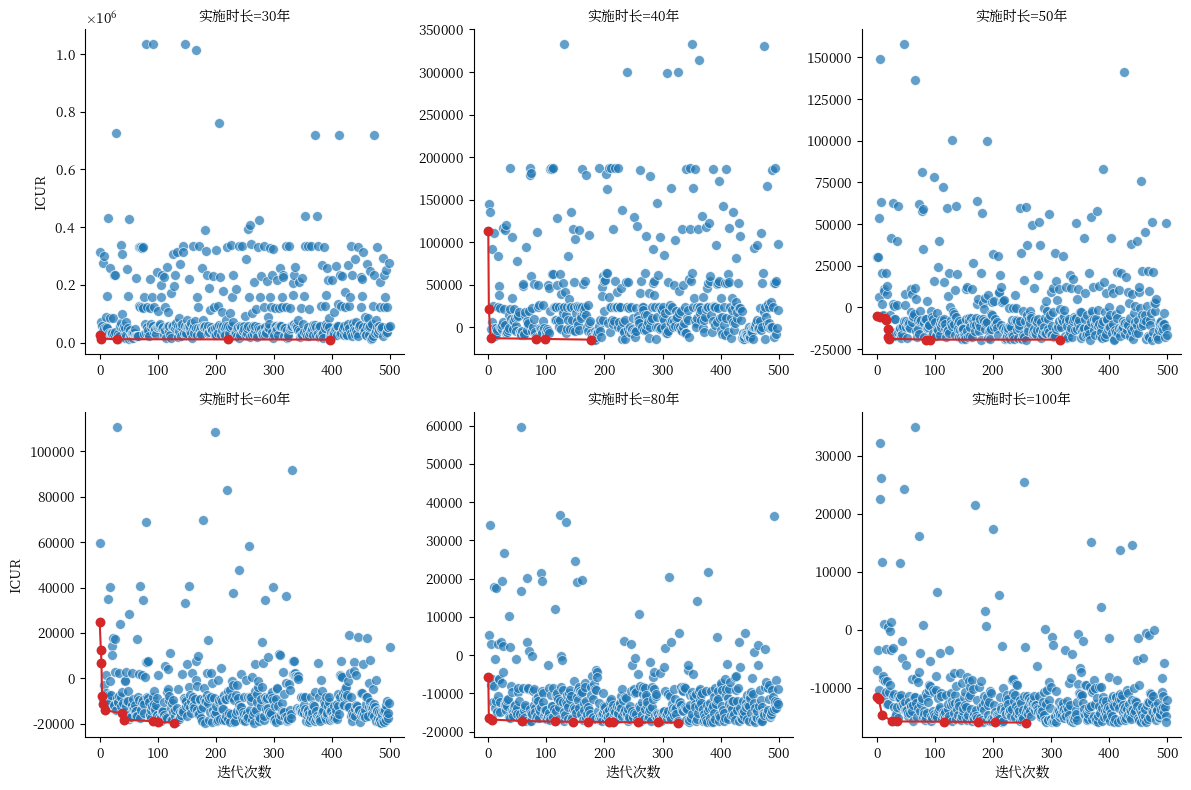

In [15]:
cmap = sns.color_palette()
fg = sns.relplot(data=df_hist.query("discount == 'nodisc'"), x="Trial", y="ICUR",
                 col="strategy", col_wrap=3, alpha=0.7, s=50,
                 facet_kws={"sharey": False, "sharex": False},
                 aspect=1.0, height=4)
fg.set_titles(col_template="实施时长={col_name}年")
fg.set_xlabels("迭代次数")
for k, ax in fg.axes_dict.items():
    dfi = df_hist.query("strategy == '%s' & discount == 'nodisc'" % k)
    dfi = dfi.loc[dfi["is_best"], :]
    ax.plot(
        dfi["Trial"].values,
        dfi["ICUR"].values,
        marker="o",
        color=cmap[3],
        alpha=1.0,
        label=None
    )
for ax in fg.axes:
    ax.ticklabel_format(style='sci', axis='y', useMathText=True)
fg.savefig("./results/optim_hist_nodisc.png")
plt.show()

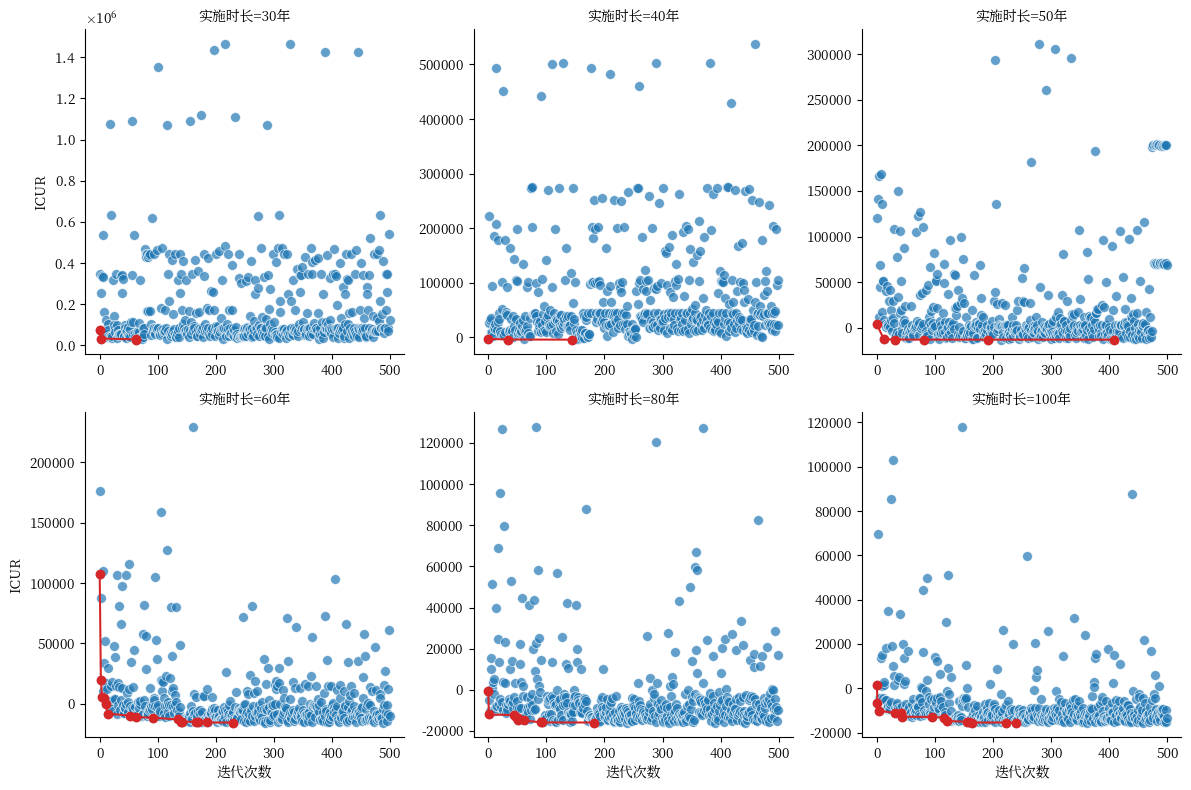

In [16]:
cmap = sns.color_palette()
fg = sns.relplot(data=df_hist.query("discount == 'disc'"), x="Trial", y="ICUR",
                 col="strategy", col_wrap=3, alpha=0.7, s=50,
                 facet_kws={"sharey": False, "sharex": False},
                 aspect=1.0, height=4)
fg.set_titles(col_template="实施时长={col_name}年")
fg.set_xlabels("迭代次数")
for k, ax in fg.axes_dict.items():
    dfi = df_hist.query("strategy == '%s' & discount == 'disc'" % k)
    dfi = dfi.loc[dfi["is_best"], :]
    ax.plot(
        dfi["Trial"].values,
        dfi["ICUR"].values,
        marker="o",
        color=cmap[3],
        alpha=1.0,
        label=None
    )
for ax in fg.axes:
    ax.ticklabel_format(style='sci', axis='y', useMathText=True)
fg.savefig("./results/optim_hist_disc.png")
plt.show()

## Figure(帕累托优化结果)

In [17]:
df_pareto = []
for k in d_results.keys():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        dfi = []
        for trial in d_trials[k][i]:
            value = {"Trial": trial.number,
                     "ICUR": trial.values[0],
                     "Incidence": trial.values[1]}
            dfi.append(value)
        dfi = pd.DataFrame.from_records(dfi)

        best_indice = []
        best_icer, bbest_ind = np.inf, None
        for trial in d_best_trials[k][i]:
            best_indice.append(trial.number)
            if trial.values[0] < best_icer and trial.values[1] <= 4e-5:
                best_icer = trial.values[0]
                bbest_ind = trial.number
        dfi["best"] = "非帕累托前沿策略"
        dfi.loc[dfi["Trial"].isin(best_indice), "best"] = "帕累托前沿策略"
        dfi["best"] = pd.Categorical(dfi["best"], categories=["非帕累托前沿策略", "帕累托前沿策略"], ordered=True)
        # dfi.loc[dfi.Trial == bbest_ind, "best"] = "Choice"

        dfi["strategy"] = d_duration[k]
        dfi["discount"] = disc_flag
        df_pareto.append(dfi)
df_pareto = pd.concat(df_pareto)
df_pareto["ICUR"] = df_pareto["ICUR"] * exchange_rate
df_pareto.head()

,Trial,ICUR,Incidence,best,strategy,discount
0,0,25140.263898,0.000166,非帕累托前沿策略,30,nodisc
1,1,315411.266723,0.000161,非帕累托前沿策略,30,nodisc
2,2,13773.394998,0.000131,帕累托前沿策略,30,nodisc
3,3,72372.009213,0.000120,非帕累托前沿策略,30,nodisc
4,4,57294.580289,0.000112,非帕累托前沿策略,30,nodisc


/tmp/ipykernel_2969/3083792428.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  fg = sns.relplot(


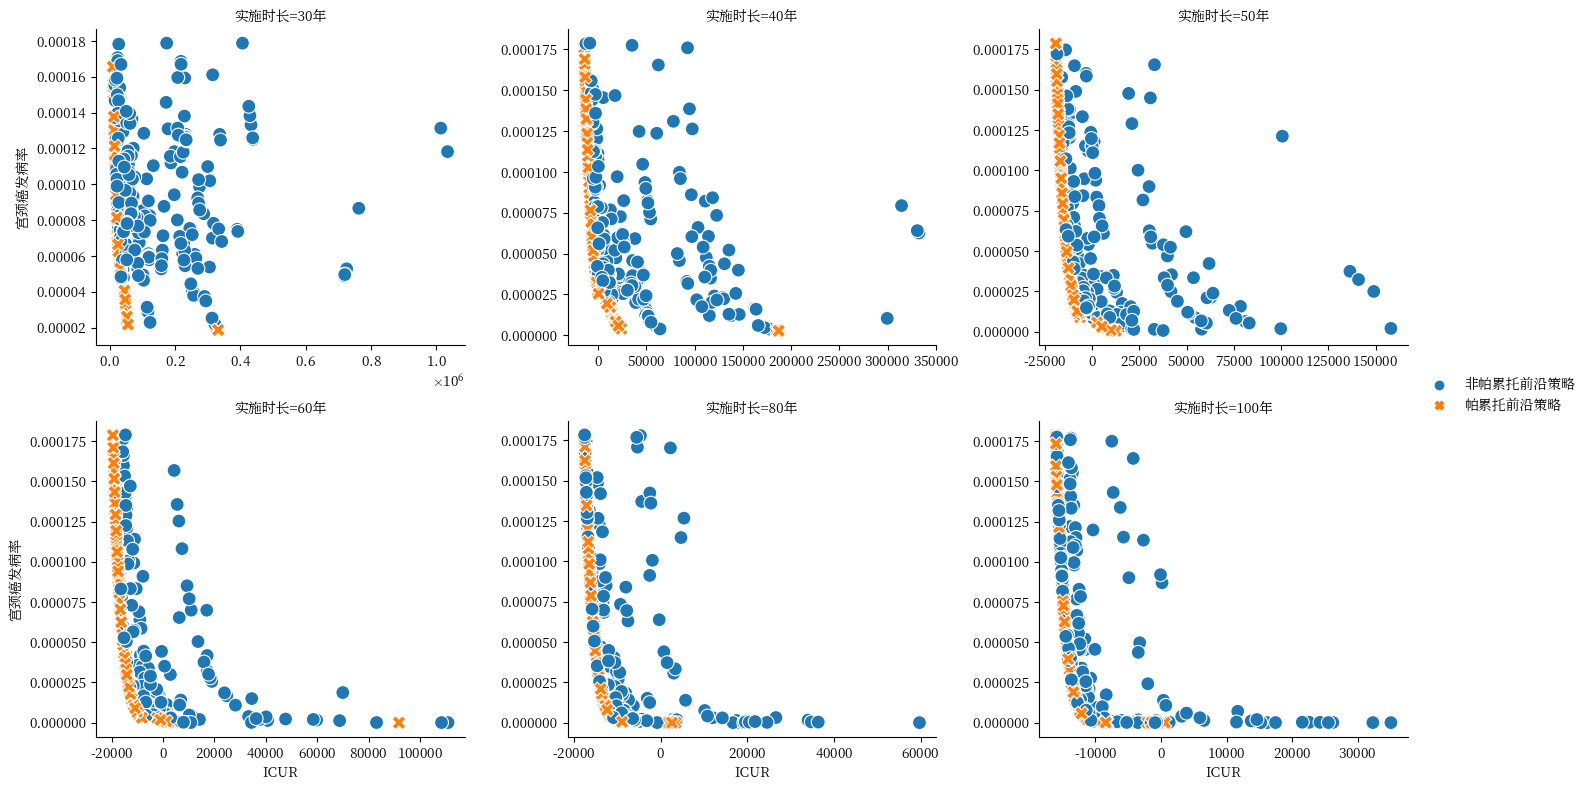

In [19]:
cmap = sns.color_palette()
fg = sns.relplot(
    data=df_pareto.query("discount == 'nodisc'"), x="ICUR", y="Incidence", hue="best", style="best",
     col="strategy", col_wrap=3, alpha=1.0,
     facet_kws={"sharey": False, "sharex": False},
     aspect=1.2, palette=[cmap[0], cmap[1], cmap[3]],
     s=100, height=4,
     # sizes={"Trial": 50, "Best Trial": 90, "Choice": 300}
)
fg.set_titles(col_template="实施时长={col_name}年")
fg.set_ylabels("宫颈癌发病率")
# fg.refline(y=0.00004)
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='sci', axis='x', useMathText=True)
fg.savefig("./results/pareto_nodisc.png")
plt.show()

/tmp/ipykernel_2969/2569867454.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  fg = sns.relplot(


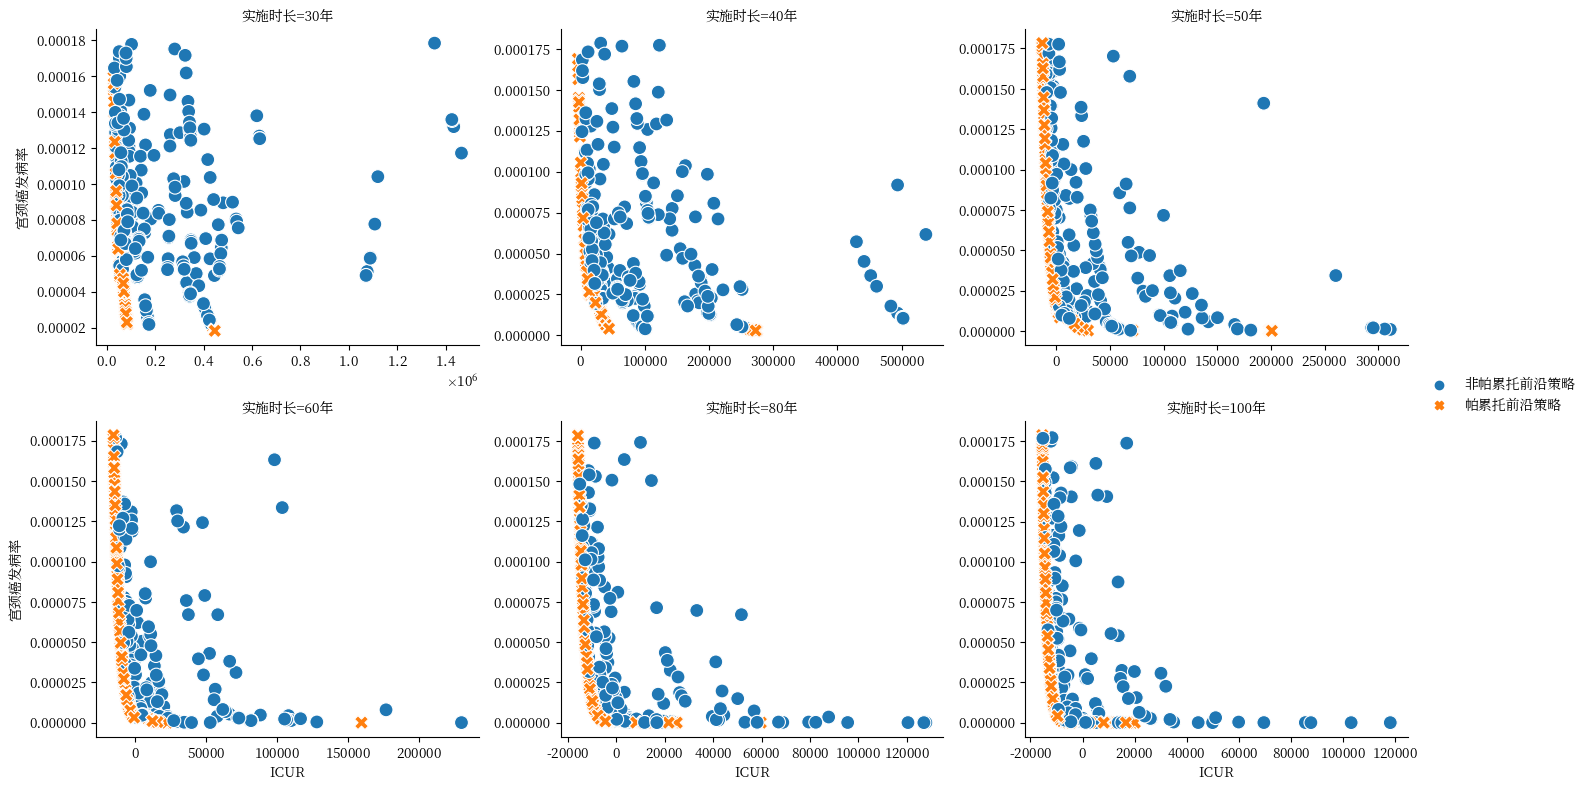

In [20]:
cmap = sns.color_palette()
fg = sns.relplot(
    data=df_pareto.query("discount == 'disc'"), x="ICUR", y="Incidence", hue="best", style="best",
     col="strategy", col_wrap=3, alpha=1.0,
     facet_kws={"sharey": False, "sharex": False},
     aspect=1.2, palette=[cmap[0], cmap[1], cmap[3]],
     s=100, height=4,
     # sizes={"Trial": 50, "Best Trial": 90, "Choice": 300}
)
fg.set_titles(col_template="实施时长={col_name}年")
fg.set_ylabels("宫颈癌发病率")
# fg.refline(y=0.00004)
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='sci', axis='x', useMathText=True)
fg.savefig("./results/pareto_disc.png")
plt.show()

# 成本

## 计算成本

In [14]:
df_cost = []
for k, evals in d_evals.items():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        eval_tar, eval_ref = evals[disc_flag]
        t = eval_tar.t_
        if disc_flag == "nodisc":
            tar_n_vacc = eval_tar.number_vacc_.sum(axis=1)
            tar_cost_vacc = eval_tar.cost_vacc_
            tar_cost_cecx = eval_tar.cost_cecx_
            diff_cost_cecx = eval_ref.cost_cecx_ - eval_tar.cost_cecx_
        else:
            tar_n_vacc = eval_tar.number_vacc_.sum(axis=1)
            tar_cost_vacc = eval_tar.cost_vacc_disc_
            tar_cost_cecx = eval_tar.cost_cecx_disc_
            diff_cost_cecx = eval_ref.cost_cecx_disc_ - eval_tar.cost_cecx_disc_
        net_cost = tar_cost_vacc - diff_cost_cecx
        
        dfi = pd.DataFrame({
            "t": t,
            "接种人数(万人)": tar_n_vacc / 10000 ,
            "疫苗成本(万元)": tar_cost_vacc / 10000 * exchange_rate,
            "节约治疗成本(万元)": diff_cost_cecx / 10000 * exchange_rate,
            "净成本(万元)": net_cost / 10000 * exchange_rate
        })
        
        dfi["strategy"] = k
        dfi["discount"] = disc_flag
        df_cost.append(dfi)
    
df_cost = pd.concat(df_cost)
df_cost.head()

,t,接种人数(万人),疫苗成本(万元),节约治疗成本(万元),净成本(万元),strategy,discount
0,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,情景1,nodisc
1,1.0,684.561420,7.232901e+05,110.039557,7.231801e+05,情景1,nodisc
2,2.0,1236.471072,1.306424e+06,1417.991794,1.305006e+06,情景1,nodisc
3,3.0,1719.130872,1.816390e+06,5911.041303,1.810479e+06,情景1,nodisc
4,4.0,2165.621573,2.288140e+06,15692.866356,2.272448e+06,情景1,nodisc


## Table

In [15]:
df_cost_table = df_cost.groupby(["strategy", "discount"]).apply(lambda df: df.sort_values("t").iloc[-1]).drop(columns=["strategy", "discount"]).unstack()
df_cost_table.round(2)

t         接种人数(万人)              疫苗成本(万元)               \
discount   disc nodisc      disc    nodisc        disc       nodisc   
strategy                                                              
情景1        30.0   30.0  12754.46  12808.41  9246215.21  13533040.44   
情景2        40.0   40.0  10865.02  11145.28  4579136.31   7850547.50   
情景3        50.0   50.0   9152.43   9213.78  3429698.83   6490030.56   
情景4        60.0   60.0   8598.57   8567.42  2886212.03   6034741.86   
情景5        80.0   80.0   8374.95   8708.71  2299223.31   6134269.49   
情景6       100.0  100.0   8630.33   8627.83  1982617.34   6077296.33   

          节约治疗成本(万元)                  净成本(万元)               
discount        disc       nodisc        disc       nodisc  
strategy                                                    
情景1       3490732.40   6454756.25  5755482.81   7078284.19  
情景2       3629617.90   8477316.39   949518.41   -626768.89  
情景3       3991767.18  11106755.41  -562068.35  -4616724.85  
情景4       4314865.16  14175070.21 -1428653.13  -8140328.35  
情景5       4653760.95  21510733.64 -2354537.64 -15376464.15  
情景6       4738203.43  28211743.58 -2755586.10 -22134447.25

In [16]:
df_cost_table.to_excel("./results/cost.xlsx")

## Figure

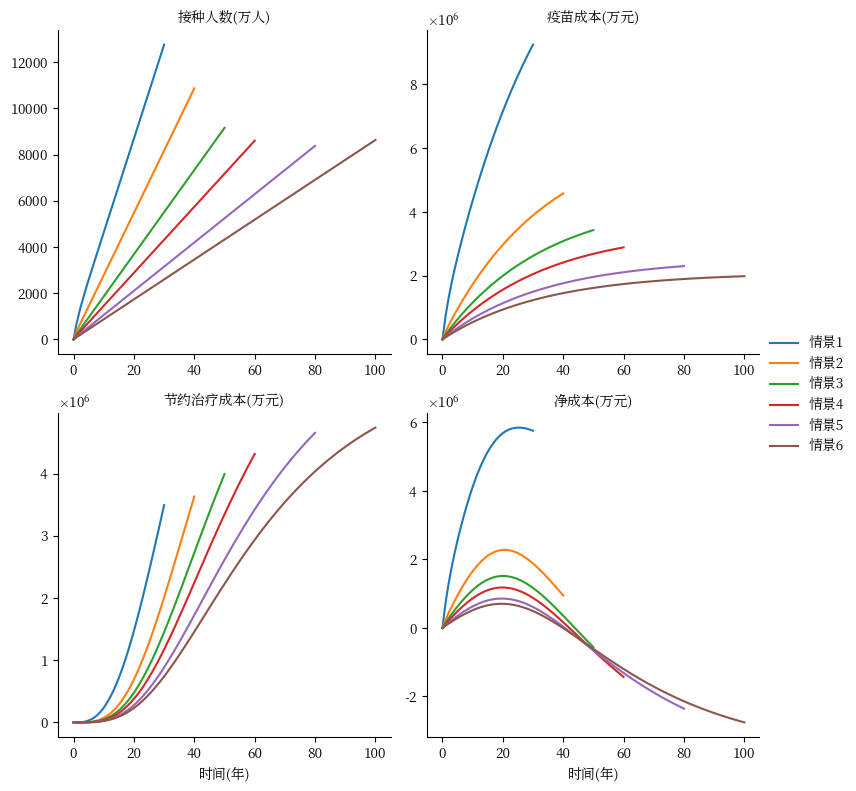

In [44]:
# 现在只有贴现的情况
df_cost_long = df_cost.melt(id_vars=["t", "strategy", "discount"], var_name="var", value_name="value").query("discount == 'disc'").rename(columns={"strategy": "策略", "discount": "贴现"}).replace({"贴现": {"nodisc": "无", "disc": "有"}})
fg = sns.relplot(data=df_cost_long, x="t", y="value", hue="策略", # , style="贴现",
                 col="var", col_wrap=2,
                 facet_kws={"sharey": False, "sharex": False},
                 aspect=1.0, kind="line", height=4)
fg.set_titles(col_template="{col_name}")
fg.set_xlabels("时间(年)")
fg.set_ylabels("")
# fg.refline(y=4e-5)
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='sci', axis='y', useMathText=True)
plt.show()

In [45]:
fg.savefig("./results/cost.png")

# 发病率

## 计算发病率

In [21]:
df_inci = []
for k, evals in d_evals.items():
    eval_tar, eval_ref = evals["nodisc"]
    del eval_tar.incidence_
    eval_tar.cal_incidence(reduce=True)
    dfi = pd.DataFrame({"t": eval_tar.t_, "inci": eval_tar.incidence_.copy()})
    dfi["strategy"] = k
    df_inci.append(dfi)

    if d_duration[k] == "100":
        dfi = pd.DataFrame({"t": eval_ref.t_, "inci": eval_ref.incidence_.copy()})
        dfi["strategy"] = "无疫苗接种"
        df_inci.append(dfi)
    
df_inci = pd.concat(df_inci, axis=0)
df_inci["strategy"] = pd.Categorical(df_inci["strategy"], categories=["无疫苗接种"] + list(d_evals.keys()))
df_inci.head()

,t,inci,strategy
0,0.0,0.000179,情景1
1,1.0,0.000179,情景1
2,2.0,0.000178,情景1
3,3.0,0.000177,情景1
4,4.0,0.000175,情景1


In [22]:
# 年龄组发病率
df_inci_ages = []
for k, evals in d_evals.items():
    eval_tar, eval_ref = evals["nodisc"]
    model = eval_tar.model
    del eval_tar.incidence_
    inci = eval_tar.cal_incidence(reduce=False).incidence_.copy()
    dfi = pd.DataFrame({
        "t": np.repeat(eval_tar.t_, inci.shape[1]),
        "age": pd.Categorical(np.tile(model.agebin_names, inci.shape[0]), categories=model.agebin_names, ordered=True),
        "inci": inci.flatten()
    })
    dfi["strategy"] = k
    df_inci_ages.append(dfi)
    
df_inci_ages = pd.concat(df_inci_ages)
print(df_inci_ages.shape)
df_inci_ages.head()

(9516, 4)


,t,age,inci,strategy
0,0.0,"[0, 1)",-3.574766e-124,情景1
1,0.0,"[1, 9)",5.092164e-125,情景1
2,0.0,"[9, 10)",-1.518665e-122,情景1
3,0.0,"[10, 11)",4.796535e-120,情景1
4,0.0,"[11, 12)",-1.440458e-117,情景1


## Figure(总体发病率)

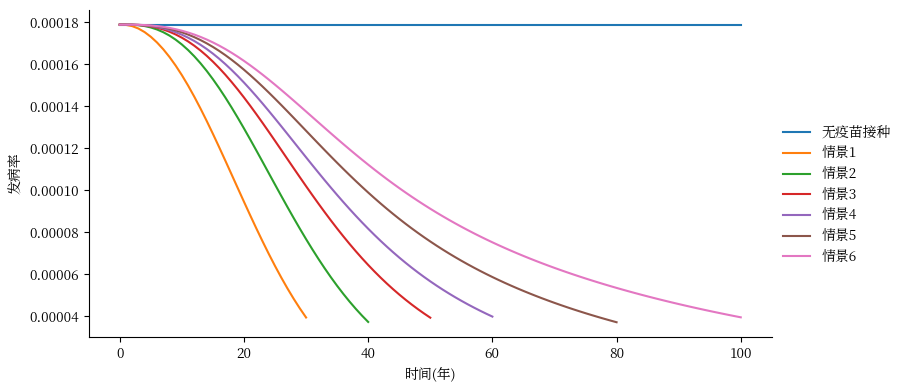

In [23]:
fg = sns.relplot(
    data=df_inci, x="t", y="inci", hue="strategy", kind="line",
    aspect=2, height=4
)
fg.set_xlabels("时间(年)")
fg.set_ylabels("发病率")
fg._legend.set_title("")
plt.show()

In [24]:
fg.savefig("./results/incidence.png")

## Figure(年龄组发病率)

In [25]:
df_inci_ages_last = df_inci_ages.groupby(["strategy", "age"]).apply(lambda df: df.sort_values("t").iloc[-1])
df_inci_ages_last.head()

t       age           inci strategy
strategy age                                             
情景1      [0, 1)    30.0    [0, 1) -8.944426e-142      情景1
         [1, 9)    30.0    [1, 9)  1.274132e-142      情景1
         [9, 10)   30.0   [9, 10) -3.799807e-140      情景1
         [10, 11)  30.0  [10, 11)  1.199961e-137      情景1
         [11, 12)  30.0  [11, 12) -3.602439e-135      情景1

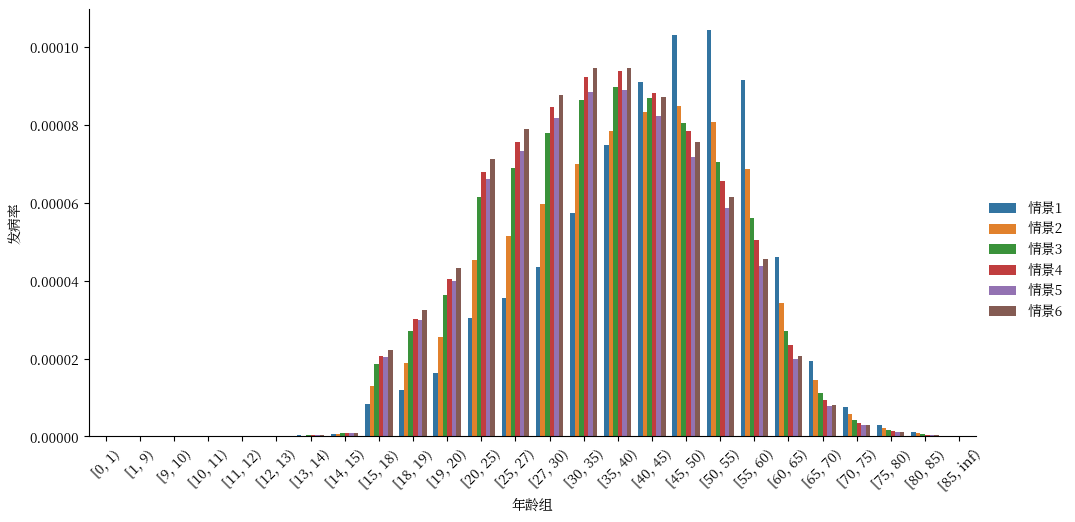

In [26]:
fg = sns.catplot(
    data=df_inci_ages_last, x="age", y="inci", hue="strategy", kind="bar",
    aspect=2
)
# sns.lineplot(data=df_inci_ages_last, x="age", y="inci", hue="strategy", ax=fg.ax)
fg.set_xlabels("年龄组")
fg.set_ylabels("发病率")
fg.set_xticklabels(rotation=45)
fg._legend.set_title("")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [27]:
fg.savefig("./results/incidence_age.png")

## Figure(随时间变化的年龄组发病率)

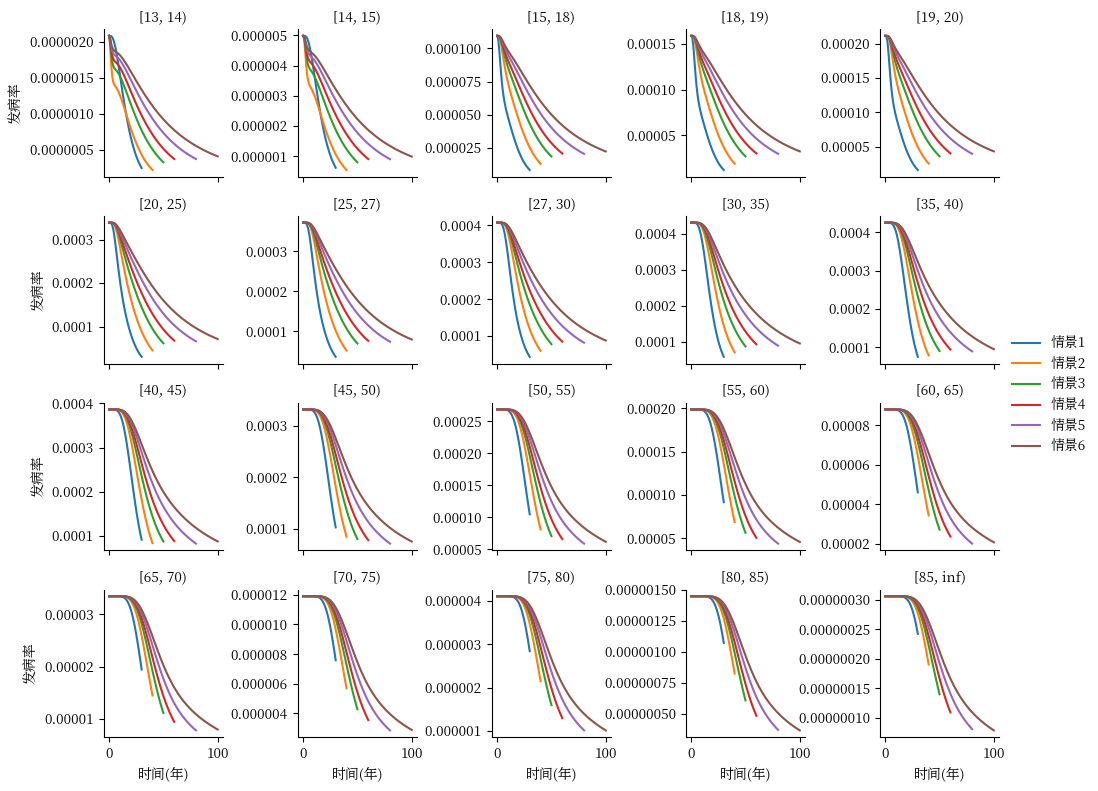

In [28]:
df_plot = df_inci_ages[df_inci_ages.age > "[12, 13)"].copy()
df_plot["age"] = df_plot.age.cat.remove_unused_categories()
fg = sns.relplot(
    data=df_plot, x="t", y="inci", hue="strategy", col="age",
    col_wrap=5, height=2, kind="line", facet_kws={"sharey": False}
)
fg.set_titles(col_template="{col_name}")
fg.set_ylabels("发病率")
fg.set_xlabels("时间(年)")
fg._legend.set_title("")
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [29]:
fg.savefig("./results/incidence_age_time.png")

# 宫颈癌死亡率

## 计算死亡率

In [30]:
df_mort = []
for k, evals in d_evals.items():
    eval_tar, eval_ref = evals["nodisc"]
    del eval_tar.mortality_
    eval_tar.cal_mortality(reduce=True)
    dfi = pd.DataFrame({"t": eval_tar.t_, "mort": eval_tar.mortality_.copy()})
    dfi["strategy"] = k
    df_mort.append(dfi)

    if d_duration[k] == "100":
        dfi = pd.DataFrame({"t": eval_ref.t_, "mort": eval_ref.mortality_.copy()})
        dfi["strategy"] = "无疫苗接种"
        df_mort.append(dfi)
    
df_mort = pd.concat(df_mort, axis=0)
df_mort["strategy"] = pd.Categorical(df_mort["strategy"], categories=["无疫苗接种"] + list(d_evals.keys()))
df_mort.head()

,t,mort,strategy
0,0.0,0.000034,情景1
1,1.0,0.000034,情景1
2,2.0,0.000034,情景1
3,3.0,0.000034,情景1
4,4.0,0.000034,情景1


In [31]:
# 年龄组发病率
df_mort_ages = []
for k, evals in d_evals.items():
    eval_tar, eval_ref = evals["nodisc"]
    model = eval_tar.model
    del eval_tar.mortality_
    mort = eval_tar.cal_mortality(reduce=False).mortality_.copy()
    dfi = pd.DataFrame({
        "t": np.repeat(eval_tar.t_, mort.shape[1]),
        "age": pd.Categorical(np.tile(model.agebin_names, mort.shape[0]), categories=model.agebin_names, ordered=True),
        "mort": mort.flatten()
    })
    dfi["strategy"] = k
    df_mort_ages.append(dfi)
    
df_mort_ages = pd.concat(df_mort_ages)
print(df_mort_ages.shape)
df_mort_ages.head()

(9516, 4)


,t,age,mort,strategy
0,0.0,"[0, 1)",0.0,情景1
1,0.0,"[1, 9)",0.0,情景1
2,0.0,"[9, 10)",0.0,情景1
3,0.0,"[10, 11)",0.0,情景1
4,0.0,"[11, 12)",0.0,情景1


## Figure(总体死亡率)

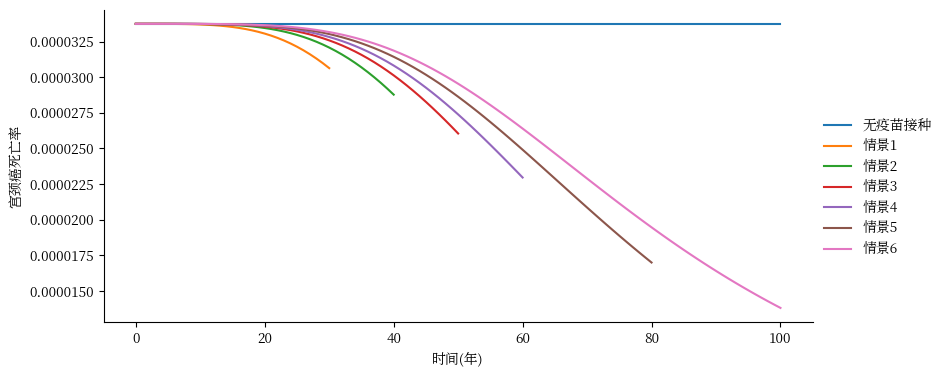

In [32]:
fg = sns.relplot(
    data=df_mort, x="t", y="mort", hue="strategy", kind="line",
    aspect=2, height=4
)
fg.set_xlabels("时间(年)")
fg.set_ylabels("宫颈癌死亡率")
fg._legend.set_title("")
fg.ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [33]:
fg.savefig("./results/mortality.png")

## Figure(年龄组发病率)

In [34]:
df_mort_ages_last = df_mort_ages.groupby(["strategy", "age"]).apply(lambda df: df.sort_values("t").iloc[-1])
df_mort_ages_last.head()

t       age  mort strategy
strategy age                                    
情景1      [0, 1)    30.0    [0, 1)   0.0      情景1
         [1, 9)    30.0    [1, 9)   0.0      情景1
         [9, 10)   30.0   [9, 10)   0.0      情景1
         [10, 11)  30.0  [10, 11)   0.0      情景1
         [11, 12)  30.0  [11, 12)   0.0      情景1

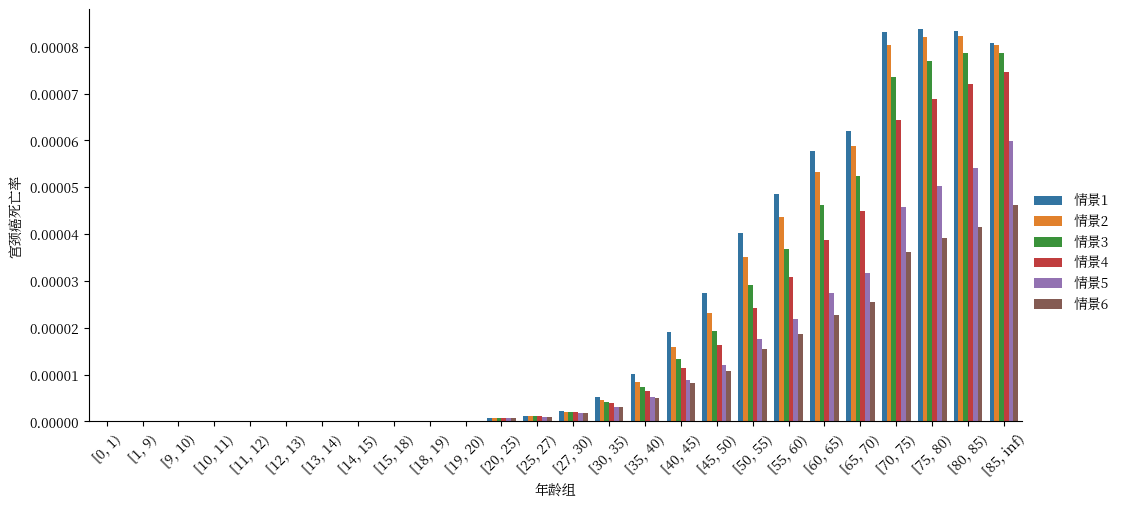

In [35]:
fg = sns.catplot(
    data=df_mort_ages_last, x="age", y="mort", hue="strategy", kind="bar",
    aspect=2
)
# sns.lineplot(data=df_inci_ages_last, x="age", y="inci", hue="strategy", ax=fg.ax)
fg.set_xlabels("年龄组")
fg.set_ylabels("宫颈癌死亡率")
fg.set_xticklabels(rotation=45)
fg._legend.set_title("")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [36]:
fg.savefig("./results/mortality_age.png")

## Figure(随时间变化的年龄组发病率)

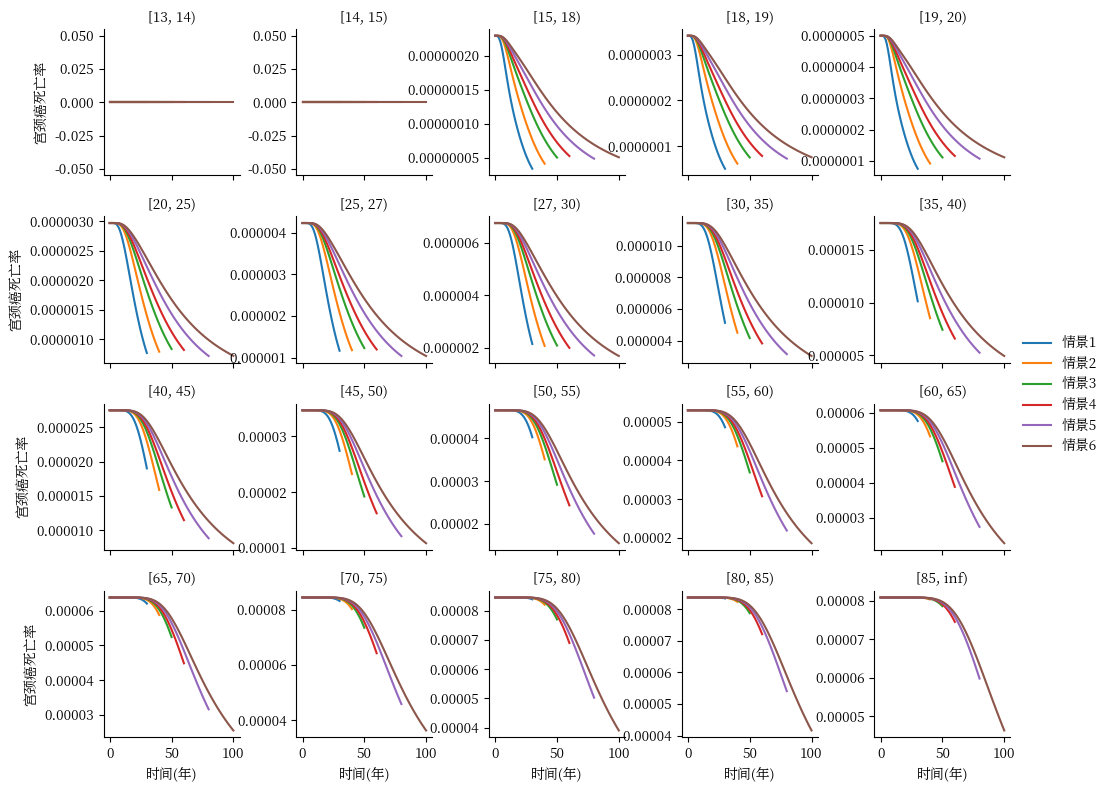

In [37]:
df_plot = df_mort_ages[df_mort_ages.age > "[12, 13)"].copy()
df_plot["age"] = df_plot.age.cat.remove_unused_categories()
fg = sns.relplot(
    data=df_plot, x="t", y="mort", hue="strategy", col="age",
    col_wrap=5, height=2, kind="line", facet_kws={"sharey": False}
)
fg.set_titles(col_template="{col_name}")
fg.set_ylabels("宫颈癌死亡率")
fg.set_xlabels("时间(年)")
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y')
fg._legend.set_title("")
plt.show()

In [38]:
fg.savefig("./results/mortality_age_time.png")

# 增量效果成本比

## 计算各项增量效果成本比

In [46]:
df_ICUR = []
for k, evals in d_evals.items():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        eval_tar, eval_ref = evals[disc_flag]
        eval_tar.cal_avoid_cecx(eval_ref)
        eval_tar.cal_avoid_cecxDeath(eval_ref)
        t = eval_tar.t_
        if disc_flag == "nodisc":
            tar_cost_vacc = eval_tar.cost_vacc_
            tar_cost_cecx = eval_tar.cost_cecx_
            diff_cost_cecx = eval_ref.cost_cecx_ - eval_tar.cost_cecx_
            icur = eval_tar.icur_
            avoid_daly = (eval_ref.daly_nofatal_ + eval_ref.daly_fatal_ + eval_ref.lifeloss_) - (eval_tar.daly_nofatal_ + eval_tar.daly_fatal_ + eval_tar.lifeloss_)
        else:
            tar_cost_vacc = eval_tar.cost_vacc_disc_
            tar_cost_cecx = eval_tar.cost_cecx_disc_
            diff_cost_cecx = eval_ref.cost_cecx_disc_ - eval_tar.cost_cecx_disc_
            # avoid_cecx = eval_tar.avoid_cecx_disc_.sum(axis=1)
            # avoid_death = eval_tar.avoid_cecxDeath_disc_.sum(axis=1)
            icur = eval_tar.icur_disc_
            avoid_daly = (eval_ref.daly_nofatal_disc_ + eval_ref.daly_fatal_disc_ + eval_ref.lifeloss_disc_) - (eval_tar.daly_nofatal_disc_ + eval_tar.daly_fatal_disc_ + eval_tar.lifeloss_disc_)
        
        avoid_cecx = eval_tar.avoid_cecx_.sum(axis=1)
        avoid_death = eval_tar.avoid_cecxDeath_.sum(axis=1)
        net_cost = tar_cost_vacc - diff_cost_cecx
        
        dfi = pd.DataFrame({
            "t": t,
            "预防的宫颈癌发病例数（万人）": avoid_cecx / 10000,
            "预防的宫颈癌死亡例数（万人）": avoid_death / 10000,
            "挽救的伤残调整寿命年（万）": avoid_daly / 10000,
            "每预防一例宫颈癌需要的增量成本": net_cost / avoid_cecx * exchange_rate,
            "每预防一例死亡需要的增量成本": net_cost / avoid_death * exchange_rate,
            "每挽救一个伤残调整寿命年需要的增量成本": icur * exchange_rate,
        })
        dfi["strategy"] = k
        dfi["discount"] = disc_flag
        df_ICUR.append(dfi)
    
df_ICUR = pd.concat(df_ICUR)
df_ICUR.head()

/tmp/ipykernel_2969/2483364881.py:32: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例宫颈癌需要的增量成本": net_cost / avoid_cecx * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:33: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例死亡需要的增量成本": net_cost / avoid_death * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:32: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例宫颈癌需要的增量成本": net_cost / avoid_cecx * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:33: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例死亡需要的增量成本": net_cost / avoid_death * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:32: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例宫颈癌需要的增量成本": net_cost / avoid_cecx * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:33: RuntimeWarning: invalid value encountered in true_divide
  "每预防一例死亡需要的增量成本": net_cost / avoid_death * exchange_rate,
/tmp/ipykernel_2969/2483364881.py:32: RuntimeWarning: invalid value en

,t,预防的宫颈癌发病例数（万人）,预防的宫颈癌死亡例数（万人）,挽救的伤残调整寿命年（万）,每预防一例宫颈癌需要的增量成本,每预防一例死亡需要的增量成本,每挽救一个伤残调整寿命年需要的增量成本,strategy,discount
0,0.0,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,情景1,nodisc
1,1.0,0.002114,4.114317e-08,0.001609,3.420687e+08,1.757716e+13,4.493481e+08,情景1,nodisc
2,2.0,0.027243,1.424300e-06,0.020796,4.790208e+07,9.162439e+11,6.275391e+07,情景1,nodisc
3,3.0,0.113566,1.156601e-05,0.087038,1.594208e+07,1.565345e+11,2.080096e+07,情景1,nodisc
4,4.0,0.301499,5.152052e-05,0.232342,7.537152e+06,4.410762e+10,9.780599e+06,情景1,nodisc


## Table

In [47]:
df_ICUR["discount"] = pd.Categorical(df_ICUR["discount"].replace({"nodisc": "无贴现", "disc": "贴现"}), categories=["无贴现", "贴现"])
res = df_ICUR.groupby(["strategy", "discount"]).apply(lambda df: df.sort_values("t").iloc[-1]).drop(columns=["t", "strategy", "discount"]).unstack().round(2)
res

预防的宫颈癌发病例数（万人）         预防的宫颈癌死亡例数（万人）        挽救的伤残调整寿命年（万）          \
discount            无贴现      贴现            无贴现     贴现           无贴现      贴现   
strategy                                                                      
情景1              124.01  123.66           1.40   1.40        154.33   80.70   
情景2              162.87  160.24           2.90   2.84        235.86   95.81   
情景3              213.39  212.46           5.99   5.95        367.96  122.35   
情景4              272.34  272.99          10.91  10.94        546.37  149.62   
情景5              413.28  402.98          27.02  26.24       1037.87  190.75   
情景6              542.02  542.12          47.11  47.12       1561.53  213.19   

         每预防一例宫颈癌需要的增量成本           每预防一例死亡需要的增量成本              \
discount             无贴现        贴现            无贴现          贴现   
strategy                                                        
情景1             57077.35  46541.56     5039213.82  4113146.05   
情景2             -3848.26   5925.62     -215862.93   333836.34   
情景3            -21635.28  -2645.53     -771308.90   -94405.61   
情景4            -29890.45  -5233.43     -746237.31  -130595.65   
情景5            -37206.34  -5842.75     -569016.66   -89721.11   
情景6            -40837.06  -5082.97     -469873.38   -58483.59   

         每挽救一个伤残调整寿命年需要的增量成本            
discount                 无贴现        贴现  
strategy                                
情景1                 45864.05  71320.85  
情景2                 -2657.36   9910.04  
情景3                -12546.93  -4593.76  
情景4                -14898.82  -9548.46  
情景5                -14815.39 -12343.89  
情景6                -14174.83 -12925.43

In [48]:
res.to_excel("./results/avoid.xlsx")

## Figure

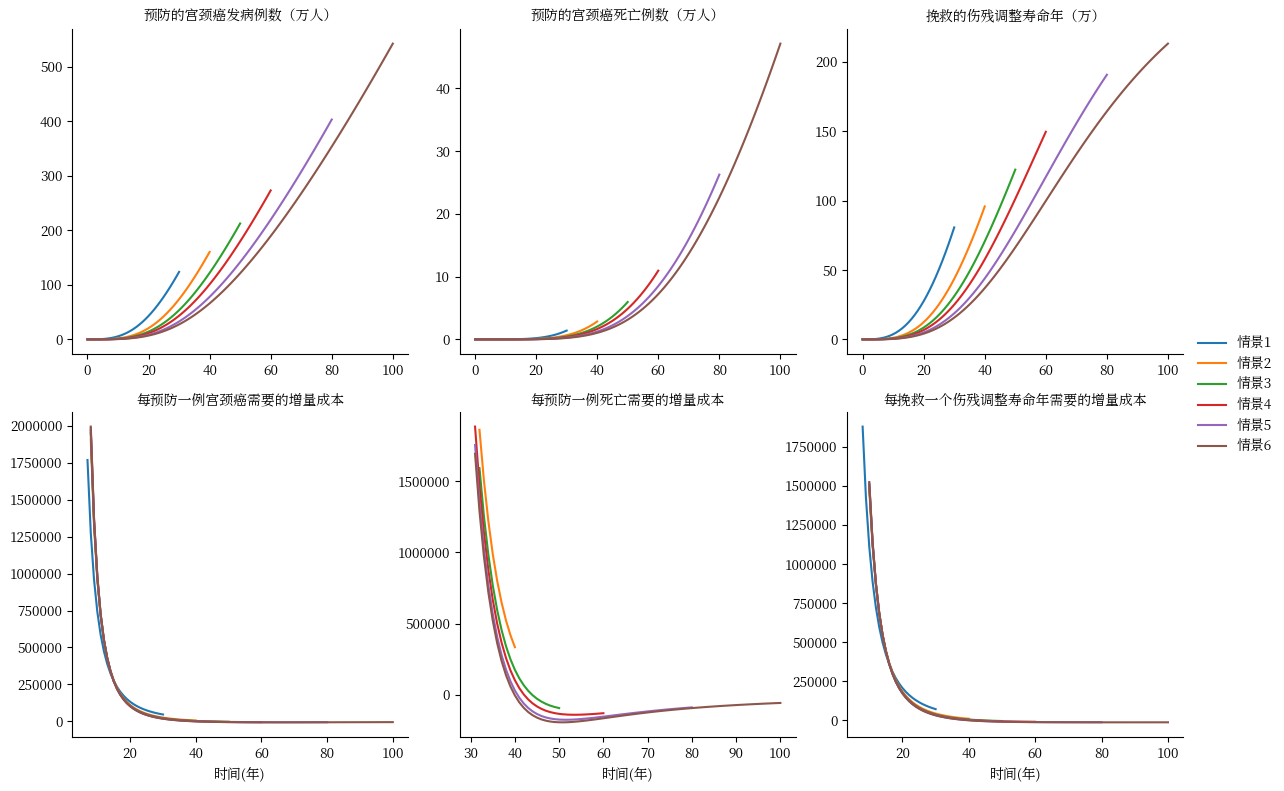

In [49]:
# 只可视化贴现的结果
df_ICUR_long = df_ICUR.melt(id_vars=["t", "strategy", "discount"], var_name="var", value_name="value").query("discount == '贴现'").replace({"discount": {"nodisc": "否", "disc": "是"}}).rename(columns={"strategy": "策略", "discount": "贴现"})
df_ICUR_long = df_ICUR_long.query("value < 2000000")
fg = sns.relplot(
    data=df_ICUR_long, x="t", y="value", hue="策略", #  style="贴现",
    col="var", col_wrap=3,
    facet_kws={"sharey": False,"sharex": False},
    aspect=1.0, kind="line", height=4,
)
fg.set_titles(col_template="{col_name}")
fg.set_xlabels("时间(年)")
fg.set_ylabels("")
# fg.refline(y=4e-5)
for ax in fg.axes:
    ax.ticklabel_format(style='plain', axis='y')
fg._legend.set_title("")
plt.show()

In [50]:
fg.savefig("./results/avoid.png")

# 每年发病和死亡人数

In [44]:
df_number = []
disc_map = {"nodisc": "无贴现", "disc": "贴现"}
for disc_flag in ["nodisc", "disc"]:
    eval_tar, eval_ref = d_evals["情景2"][disc_flag]
    dfi = pd.DataFrame({"t": eval_tar.t_, "发病人数": eval_tar.number_cecx_.sum(axis=1), "死亡人数": eval_tar.number_cecxDeath_.sum(axis=1)})
    dfi["discount"] = disc_map[disc_flag]
    dfi["type"] = "实施策略后"
    df_number.append(dfi)
    
    dfi = pd.DataFrame({"t": eval_ref.t_, "发病人数": eval_ref.number_cecx_.sum(axis=1), "死亡人数": eval_ref.number_cecxDeath_.sum(axis=1)})
    dfi["discount"] = disc_map[disc_flag]
    dfi["type"] = "实施策略前"
    df_number.append(dfi)
    
df_number = pd.concat(df_number)
df_number.head()

,t,发病人数,死亡人数,discount,type
0,0.0,0.000000,0.000000,无贴现,实施策略后
1,1.0,127202.658773,23988.650842,无贴现,实施策略后
2,2.0,254387.341753,47977.249744,无贴现,实施策略后
3,3.0,381489.034195,71965.790455,无贴现,实施策略后
4,4.0,508382.686479,95954.245316,无贴现,实施策略后


In [45]:
df_number["discount"] = pd.Categorical(df_number["discount"], categories=["无贴现", "贴现"], ordered=True)
df_number["type"] = pd.Categorical(df_number["type"], categories=["实施策略前", "实施策略后"], ordered=True)
df_pivot = df_number.pivot(index="t", columns=["type", "discount"])

In [46]:
df_pivot

发病人数                                            \
type             实施策略后         实施策略前         实施策略后         实施策略前   
discount           无贴现           无贴现            贴现            贴现   
t                                                                  
0.0       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1.0       1.272027e+05  1.272036e+05  1.272027e+05  1.272036e+05   
2.0       2.543873e+05  2.544069e+05  2.543880e+05  2.544069e+05   
3.0       3.814890e+05  3.816099e+05  3.814928e+05  3.816099e+05   
4.0       5.083827e+05  5.088127e+05  5.083957e+05  5.088127e+05   
5.0       6.348965e+05  6.360152e+05  6.349294e+05  6.360152e+05   
6.0       7.608292e+05  7.632174e+05  7.608979e+05  7.632174e+05   
7.0       8.859621e+05  8.904194e+05  8.860878e+05  8.904194e+05   
8.0       1.010065e+06  1.017621e+06  1.010275e+06  1.017621e+06   
9.0       1.132901e+06  1.144822e+06  1.133226e+06  1.144822e+06   
10.0      1.254227e+06  1.272024e+06  1.254705e+06  1.272024e+06   
11.0      1.373799e+06  1.399224e+06  1.374471e+06  1.399224e+06   
12.0      1.491371e+06  1.526425e+06  1.492284e+06  1.526425e+06   
13.0      1.606703e+06  1.653625e+06  1.607907e+06  1.653625e+06   
14.0      1.719560e+06  1.780825e+06  1.721110e+06  1.780825e+06   
15.0      1.829721e+06  1.908025e+06  1.831673e+06  1.908025e+06   
16.0      1.936974e+06  2.035225e+06  1.939388e+06  2.035225e+06   
17.0      2.041128e+06  2.162424e+06  2.044063e+06  2.162424e+06   
18.0      2.142007e+06  2.289623e+06  2.145526e+06  2.289623e+06   
19.0      2.239460e+06  2.416822e+06  2.243623e+06  2.416822e+06   
20.0      2.333355e+06  2.544020e+06  2.338223e+06  2.544020e+06   
21.0      2.423586e+06  2.671218e+06  2.429218e+06  2.671218e+06   
22.0      2.510070e+06  2.798416e+06  2.516524e+06  2.798416e+06   
23.0      2.592750e+06  2.925614e+06  2.600081e+06  2.925614e+06   
24.0      2.671593e+06  3.052811e+06  2.679851e+06  3.052811e+06   
25.0      2.746590e+06  3.180008e+06  2.755822e+06  3.180008e+06   
26.0      2.817752e+06  3.307205e+06  2.828003e+06  3.307205e+06   
27.0      2.885117e+06  3.434401e+06  2.896425e+06  3.434401e+06   
28.0      2.948739e+06  3.561597e+06  2.961137e+06  3.561597e+06   
29.0      3.008690e+06  3.688793e+06  3.022208e+06  3.688793e+06   
30.0      3.065061e+06  3.815989e+06  3.079722e+06  3.815989e+06   
31.0      3.117956e+06  3.943184e+06  3.133779e+06  3.943184e+06   
32.0      3.167491e+06  4.070380e+06  3.184489e+06  4.070380e+06   
33.0      3.213794e+06  4.197575e+06  3.231975e+06  4.197575e+06   
34.0      3.256998e+06  4.324769e+06  3.276365e+06  4.324769e+06   
35.0      3.297244e+06  4.451963e+06  3.317796e+06  4.451963e+06   
36.0      3.334676e+06  4.579157e+06  3.356408e+06  4.579157e+06   
37.0      3.369443e+06  4.706351e+06  3.392344e+06  4.706351e+06   
38.0      3.401693e+06  4.833545e+06  3.425749e+06  4.833545e+06   
39.0      3.431572e+06  4.960738e+06  3.456766e+06  4.960738e+06   
40.0      3.459225e+06  5.087931e+06  3.485537e+06  5.087931e+06   

                   死亡人数                                               
type              实施策略后          实施策略前          实施策略后          实施策略前  
discount            无贴现            无贴现             贴现             贴现  
t                                                                     
0.0            0.000000       0.000000       0.000000       0.000000  
1.0        23988.650842   23988.650847   23988.650842   23988.650847  
2.0        47977.249744   47977.250314   47977.249763   47977.250314  
3.0        71965.790455   71965.798404   71965.790710   71965.798404  
4.0        95954.245316   95954.295117   95954.246872   95954.295117  
5.0       119942.538031  119942.740458  119942.544209  119942.740458  
6.0       143930.506877  143931.134425  143930.525646  143931.134425  
7.0       167917.861030  167919.477024  167917.908519  167919.477024  
8.0       191904.132673  191907.768254  191904.237858  191907.768254  
9.0       215888.626948  215896.00

In [47]:
df_pivot.to_excel("./results/发病人数和死亡人数.xlsx")

# 将疫苗换成进口9价

In [5]:
from copy import deepcopy
from src.evaluation import Evaluator

## ICUR值

In [6]:
df_imp9 = []
for k, evals in d_evals.items():
    for i, disc_flag in enumerate(["nodisc", "disc"]):
        with open(osp.join(d_results[k][i], "best_trial.pkl"), "rb") as f:
            param = pickle.load(f).params
            
        eval_tar, eval_ref = evals[disc_flag]
        model = deepcopy(eval_tar.model)
        model.tau = 0.921
        new_eval_tar = Evaluator(
            model, init="./results/ref_warmup/last.npy",
            t_span=(0, int(d_duration[k])), n_eval=int(d_duration[k])+1,
            life_table=eval_tar.ltable, cost_per_vacc=574.71,
            cost_per_cecx=eval_tar.cost_pcecx,
            DALY_nofatal=eval_tar.daly_nof, DALY_fatal=eval_tar.daly_f,
            discount_rate=eval_tar.discount_rate
        )
        
        new_eval_tar.cal_icur(eval_ref)
        if disc_flag == "disc":
            di = {"icur": new_eval_tar.icur_disc_[-1] * exchange_rate}
        else:
            di = {"icur": new_eval_tar.icur_[-1] * exchange_rate}
        
        di["strategy"] = k
        di["discount"] = disc_flag
        
        df_imp9.append(di)
df_imp9 = pd.DataFrame.from_records(df_imp9)
df_imp9.head()

/home/luyiyun/Documents/hpv_tdm/src/evaluation.py:257: RuntimeWarning: invalid value encountered in true_divide
  self.icur_ = (tar_cost - ref_cost) / (ref_daly - tar_daly)
/home/luyiyun/Documents/hpv_tdm/src/evaluation.py:266: RuntimeWarning: invalid value encountered in true_divide
  self.icur_disc_ = (tar_cost - ref_cost) / (ref_daly - tar_daly)


,icur,strategy,discount
0,300513.686143,情景1,nodisc
1,403577.846373,情景1,disc
2,96930.504521,情景2,nodisc
3,151903.310650,情景2,disc
4,41037.046493,情景3,nodisc


In [7]:
df_imp9_wide = df_imp9.pivot(index="strategy", columns="discount", values="icur").iloc[:, ::-1]
df_imp9_wide

discount,nodisc,disc
strategy,,
情景1,300513.686143,403577.846373
情景2,96930.504521,151903.310650
情景3,41037.046493,79588.457599
情景4,19028.581686,48757.301892
情景5,3698.068826,24305.839580
情景6,-1899.863979,15377.997968


In [9]:
df_imp9_wide.to_excel("./results/icur_imp9.xlsx")

# 预算影响分析

## 价格需求曲线（R）

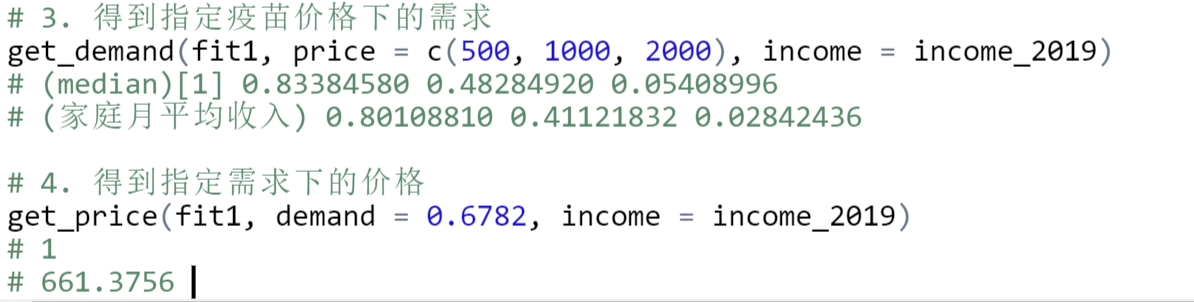

In [5]:
demand_1000 = 0.41121832  # 1000元疫苗价格下的覆盖率（需求）

## 疫苗覆盖率及费用缺口

In [53]:
demand_need = 0.6782
demand_gap = demand_need - demand_1000
print("覆盖率缺口为：%.4f" % demand_gap)
yibao_rate = demand_gap / demand_need
print("如果按照价格需求曲线计算的1000元上的需求，则个人需要负担的比例为%.4f，剩下的医保负担的比例是%.4f" % (1-yibao_rate, yibao_rate))

覆盖率缺口为：0.2670
如果按照价格需求曲线计算的1000元上的需求，则个人需要负担的比例为0.6063，剩下的医保负担的比例是0.3937


In [54]:
cost_vacc_disc = df_cost_table.loc["情景2", "疫苗成本(万元)"]["disc"]
cost_vacc_disc_ = 4579136.31
assert abs(cost_vacc_disc - cost_vacc_disc_) < 0.01

print("直接使用覆盖率缺口x疫苗花费：%.4f" % (cost_vacc_disc * demand_gap))
print("直接使用覆盖率缺口x疫苗花费/覆盖率：%.4f" % (cost_vacc_disc * demand_gap / demand_need))

直接使用覆盖率缺口x疫苗花费：1222545.5047
直接使用覆盖率缺口x疫苗花费/覆盖率：1802632.7112


## 医保预算约束下的筹资策略分析(6.4.2)

* 目标：医保支出（纳入医保后）-医保支出（纳入医保前）
* 每年费用支出，不是累计

In [6]:
from src.evaluation import Evaluator

In [7]:
def discount_rate(n):
    return np.power(1 / (1 + 0.03), np.arange(n))

In [8]:
def insurance_cost(
    evaluator: Evaluator,
    vacc_insured=1.,        # 接种人数参保比例，这里所有的人都是未成年人
    vacc_reimburse=1.,      # 疫苗接种报销比例
    minor_insured=0.869,    # 未成年人的参保比例，未成年人的参保类型全是城乡居民
    cecx_diag=0.81,  # 宫颈癌的诊断率
    cecx_treatment=0.9,  # 宫颈癌接受治疗率
    cecx_insured=(0.7569, 0.2431),  # 成年人的参保比例，分别是城乡居民和城镇职工
    cecx_reimburse=(0.479, 0.6211), # 两种保险的报销比例
    exchange_rate=6.8967,  # 汇率
):
    n_minor = 10
    
    # 累计人数
    ncecxC = evaluator.number_cecx_
    nvaccC = evaluator.number_vacc_
    # 每年人数
    ncecx = ncecxC[1:] - ncecxC[:-1]
    nvacc = nvaccC[1:] - nvaccC[:-1]
    # 实际接受治疗的人数
    ncecx_treat = ncecx * cecx_diag * cecx_treatment
    # 贴现率
    disc_rate = discount_rate(ncecx.shape[0])
    # 花费（放在前面，因为不同年龄组的疫苗花费不同，这里希望直接使用cost_pvacc_vec）
    cost_cecx = ncecx_treat * evaluator.cost_pcecx * disc_rate[:, None]
    cost_vacc = nvacc * evaluator.cost_pvacc_vec * disc_rate[:, None]
    # 成年人和未成年人
    cost_cecx_minor = cost_cecx[:, :n_minor].sum(axis=1)
    cost_cecx_adult = cost_cecx[:, n_minor:].sum(axis=1)
    cost_vacc = cost_vacc.sum(axis=1)  # 已知，所有打疫苗的都是未成年人，直接使用参数中的参保率和报销比例即可
    # cost_vacc_minor = cost_vacc[:, :n_minor].sum(axis=1)
    # cost_vacc_adult = cost_vacc[:, n_minor:].sum(axis=1)
    
    # 计算疫苗的医保花费
    cost_vacc_insurance = cost_vacc * vacc_insured * vacc_reimburse
    # 计算宫颈癌的医保花费
    cost_cecx_minor_insurance = cost_cecx_minor * minor_insured * cecx_reimburse[0]  # 未成年人只有一部分人参保，而且参保类型都是城乡居民，使用城乡居民的报销比例
    cost_cecx_adult_insurance = 0
    for insure_rate, reimb_rate in zip(cecx_insured, cecx_reimburse):
        cost_cecx_adult_insurance += cost_cecx_adult * insure_rate * reimb_rate  # 成年人的参保类型有多种，先乘以参保比例，然后乘以报销比例
    
    # 计算总的医保花费
    cost_insurance = cost_vacc_insurance + cost_cecx_minor_insurance + cost_cecx_adult_insurance
    
    df_res = pd.DataFrame({
        "接种人数": nvacc.sum(axis=1),
        "发病人数": ncecx.sum(axis=1),
        "治疗人数": ncecx_treat.sum(axis=1),
        "疫苗成本": cost_vacc * exchange_rate,
        "治疗成本": cost_cecx.sum(axis=1) * exchange_rate,
        "疫苗医保花销": cost_vacc_insurance * exchange_rate,
        "宫颈癌医保花销": (cost_cecx_minor_insurance + cost_cecx_adult_insurance) * exchange_rate,
        "总医保花销": cost_insurance * exchange_rate,
    })
    
    return df_res / 10000  # 这里用的单位是“万”，即万人和万元

In [6]:
def eval2df(evaluator, vacc_reimburse=1.0, duration=40):
    dfi = insurance_cost(evaluator, vacc_reimburse=vacc_reimburse)
    dfi["t"] = evaluator.t_[1:]
    dfi = dfi.query("t <= %d" % duration)
    dfi.set_index("t", drop=True, inplace=True)
    return dfi

def get_budget_res(vacc_reimburse=1.0, gov_rate=None, busi_rate=None, person_rate=None, eval_key="情景2"):

    duration = int(d_duration[eval_key])
    
    df_insurance_tar = eval2df(d_evals[eval_key]["disc"][0], vacc_reimburse=vacc_reimburse, duration=duration)
    df_insurance_ref = eval2df(d_evals["情景6"]["disc"][1], vacc_reimburse=vacc_reimburse, duration=duration)
    df_insurance_diff = df_insurance_tar - df_insurance_ref

    vacc_cost_all = df_insurance_tar["疫苗成本"].values
    other_money = {}
    for name, ratei in zip(["政府", "商业保险", "个人"], [gov_rate, busi_rate, person_rate]):
        if ratei is not None:
            value = vacc_cost_all * ratei
            other_money[name] = value
    other_money = pd.DataFrame(other_money, index=df_insurance_tar.index)

    columns1 = ["有疫苗接种"] * df_insurance_tar.shape[1] + ["无疫苗接种"] * df_insurance_tar.shape[1] + ["差值"] * df_insurance_tar.shape[1] + other_money.columns.tolist()
    columns2 = df_insurance_tar.columns.tolist() + df_insurance_ref.columns.tolist() + df_insurance_diff.columns.tolist() + [""] * other_money.shape[1]

    df_insurance_select = pd.concat([df_insurance_tar, df_insurance_ref, df_insurance_diff, other_money], axis=1)
    df_insurance_select.columns = pd.MultiIndex.from_arrays([columns1, columns2])
    
    df_sum = df_insurance_select.sum(axis=0)
    df_insurance_select = pd.concat([df_insurance_select, df_sum.to_frame("sum").T], axis=0)
    
    
    return df_insurance_select

In [40]:
df_insurance_select_100 = get_budget_res(vacc_reimburse=1.0)
df_insurance_select_100.to_excel("./results/insurance_select-100.xlsx")

In [50]:
# 抽取去需要的列
df_insurance_select_100_table = pd.DataFrame({
    "宫颈癌医保支出_无HPV疫苗接种": df_insurance_select_100.loc[:, "无疫苗接种"].loc[:, "宫颈癌医保花销"].values,
    "宫颈癌医保支出_最优疫苗接种": df_insurance_select_100.loc[:, "有疫苗接种"].loc[:, "宫颈癌医保花销"].values,
    "宫颈癌医保支出_医保增量": df_insurance_select_100.loc[:, "差值"].loc[:, "宫颈癌医保花销"].values,
    
    "医保总支出_无HPV疫苗接种": df_insurance_select_100.loc[:, "无疫苗接种"].loc[:, "总医保花销"].values,
    "医保总支出_最优疫苗接种": df_insurance_select_100.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
    "医保总支出_医保增量": df_insurance_select_100.loc[:, "差值"].loc[:, "总医保花销"].values,
}, index=list(range(2019, 2059)) + ["总计"])
df_insurance_select_100_table.index.name = "年份"
df_insurance_select_100_table.head()

,宫颈癌医保支出_无HPV疫苗接种,宫颈癌医保支出_最优疫苗接种,宫颈癌医保支出_医保增量,医保总支出_无HPV疫苗接种,医保总支出_最优疫苗接种,医保总支出_医保增量
年份,,,,,,
2019,246327.381183,246325.970066,-1.411117,246327.381183,482744.645299,236417.264115
2020,239152.286267,239124.104996,-28.181271,239152.286267,433821.116396,194668.830129
2021,232186.188008,232033.227691,-152.960317,232186.188008,413274.190956,181088.002947
2022,225423.003273,224956.864963,-466.138310,225423.003273,399178.772993,173755.769720
2023,218856.814352,217821.957263,-1034.857089,218856.814352,386580.365832,167723.551481


In [51]:
df_insurance_select_100_table.to_excel("./results/insurance_select-100_table.xlsx")

## 个人-医保共付的筹资策略分析(6.4.3)

In [55]:
df_insurance_select_3937 = get_budget_res(vacc_reimburse=0.3937)
df_insurance_select_3937.to_excel("./results/insurance_select-3937.xlsx")

In [56]:
df_insurance_select_7428 = get_budget_res(vacc_reimburse=0.7428)
df_insurance_select_7428.to_excel("./results/insurance_select-7428.xlsx")

In [61]:
df_insurance_select_2way = pd.DataFrame({
    "个人6063医保3937_疫苗接种成本": df_insurance_select_3937.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
    "个人6063医保3937_医保基金支出": df_insurance_select_3937.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
    "个人6063医保3937_医保增量": df_insurance_select_3937.loc[:, "差值"].loc[:, "总医保花销"].values,
    
    "个人2572医保7428_疫苗接种成本": df_insurance_select_7428.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
    "个人2572医保7428_医保基金支出": df_insurance_select_7428.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
    "个人2572医保7428_医保增量": df_insurance_select_7428.loc[:, "差值"].loc[:, "总医保花销"].values,
}, index=list(range(2019, 2059)) + ["总计"])
df_insurance_select_2way.index.name = "年份"
df_insurance_select_2way.head()

,个人6063医保3937_疫苗接种成本,个人6063医保3937_医保基金支出,个人6063医保3937_医保增量,个人2572医保7428_疫苗接种成本,个人2572医保7428_医保基金支出,个人2572医保7428_医保增量
年份,,,,,,
2019,93078.032439,339404.002505,93076.621322,175611.791963,421937.762029,175610.380846
2020,76652.213388,315776.318384,76624.032117,144620.940068,383745.045064,144592.758797
2021,71354.567237,303387.794928,71201.606920,134625.787513,366659.015204,134472.827196
2022,68591.165191,293548.030154,68125.026881,129412.033285,354368.898248,128945.894975
2023,66440.185454,284262.142717,65405.328365,125353.745885,343175.703148,124318.888797


In [62]:
df_insurance_select_2way.to_excel("./results/insurance_select-2way_table.xlsx")

In [120]:
# 计算个人2572医保7428下，个人平均需要支付的疫苗费用

# temp_df = df_insurance_select_7428.loc[:, "有疫苗接种"].iloc[:-1, :]
# cost_person = temp_df["疫苗成本"] - temp_df["疫苗医保花销"]
# disc_rate = np.power(1.03, np.arange(40))
# cost_person_nodisc = cost_person * disc_rate  # 移除贴现
# vacc_cost_person_2572 = cost_person_nodisc.sum() / df_insurance_select_7428.loc[:, "有疫苗接种"].loc["sum", "接种人数"]
# vacc_cost_person_2572 *= 3/2   # 移除两剂次的影响

# 保留贴现，只移除两剂次的影响
temp_ser = df_insurance_select_7428.loc[:, "有疫苗接种"].iloc[-1, ]
vacc_cost_person_2572 = (temp_ser.loc["疫苗成本"] - temp_ser.loc["疫苗医保花销"]) / temp_ser.loc["接种人数"] *(3/2)

print("当个人负担为25.72%%时，平均每人需要支付的疫苗花费为: %.4f" % vacc_cost_person_2572)

当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 162.5980


## 基于消费者融资偏好的三方共付筹资策略分析(6.4.3)

In [125]:
df_insurance_select_three = get_budget_res(vacc_reimburse=0.2791, gov_rate=0.2619, person_rate=0.4590)
df_insurance_select_three.to_excel("./results/insurance_select-three.xlsx")

In [130]:
df_insurance_select_three_table = pd.DataFrame({
    "医保_疫苗接种成本": df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
    "医保_医保基金支出": df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
    "医保_医保增量": df_insurance_select_three.loc[:, "差值"].loc[:, "总医保花销"].values,
    
    "政府": df_insurance_select_three.loc[:, "政府"].values,
    "个人": df_insurance_select_three.loc[:, "个人"].values,
}, index=list(range(2019, 2059)) + ["总计"])
df_insurance_select_three_table.index.name = "年份"
df_insurance_select_three_table.head()

,医保_疫苗接种成本,医保_医保基金支出,医保_医保增量,政府,个人
年份,,,,,
2019,65984.452257,312310.422323,65983.041140,61918.051043,108516.171932
2020,54339.935882,293464.040878,54311.754611,50991.147286,89365.928233
2021,50584.352847,282617.580538,50431.392530,47467.008279,83189.602138
2022,48625.334531,273582.199494,48159.196221,45628.717713,79967.855786
2023,47100.471832,264922.429095,46065.614743,44197.827204,77460.109533


In [131]:
df_insurance_select_three_table.to_excel("./results/insurance_select-three_table.xlsx")

In [138]:
# 个人人均自付
df_insurance_select_three_table.loc["总计", "个人"] / df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "接种人数"].loc["sum"]

193.44864011986434

## 基于消费者融资偏好的四方共付筹资策略分析(6.4.4)

* 加上了厂商，厂商占比为5%、10%、15%，其份额来自于医保
* 计算的时候是复用了 带有商业保险的代码，将商业保险当做厂商进行计算的，因为两者在计算上没有差别

### 5%

In [13]:
rates = [0.05, 0.10, 0.15]
df_insurance_select_four_table = []
for ratei in rates:
    df_insurance_select_four_i = get_budget_res(vacc_reimburse=0.2791-ratei, gov_rate=0.2619, person_rate=0.4590, busi_rate=ratei)

    df_insurance_select_four_table_i = pd.DataFrame({
        "医保_疫苗接种成本": df_insurance_select_four_i.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
        "医保_医保基金支出": df_insurance_select_four_i.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
        "医保_医保增量": df_insurance_select_four_i.loc[:, "差值"].loc[:, "总医保花销"].values,

        "政府": df_insurance_select_four_i.loc[:, "政府"].values,
        "个人": df_insurance_select_four_i.loc[:, "个人"].values,
        "厂商": df_insurance_select_four_i.loc[:, "商业保险"].values,
    }, index=list(range(2019, 2059)) + ["总计"])
    df_insurance_select_four_table_i.index.name = "年份"
    df_insurance_select_four_table.append(df_insurance_select_four_table_i)
    
df_insurance_select_four_table = pd.concat(df_insurance_select_four_table, axis=1, keys=["%.2f" % ratei for ratei in rates])
df_insurance_select_four_table.head()

0.05                                                            \
         医保_疫苗接种成本      医保_医保基金支出       医保_医保增量            政府             个人   
年份                                                                             
2019  54163.518496  300489.488562  54162.107378  61918.051043  108516.171932   
2020  44605.085312  283729.190308  44576.904041  50991.147286   89365.928233   
2021  41522.304684  273555.532375  41369.344367  47467.008279   83189.602138   
2022  39914.239130  264871.104093  39448.100820  45628.717713   79967.855786   
2023  38662.551403  256484.508666  37627.694314  44197.827204   77460.109533   

                            0.10                                             \
                厂商     医保_疫苗接种成本      医保_医保基金支出       医保_医保增量            政府   
年份                                                                            
2019  11820.933762  42342.584734  288668.554800  42341.173617  61918.051043   
2020   9734.850570  34870.234742  273994.339738  34842.053471  50991.147286   
2021   9062.048163  32460.256521  264493.484212  32307.296204  47467.008279   
2022   8711.095401  31203.143728  256160.008691  30737.005418  45628.717713   
2023   8437.920428  30224.630975  248046.588238  29189.773886  44197.827204   

                                           0.15                               \
                 个人            厂商     医保_疫苗接种成本      医保_医保基金支出       医保_医保增量   
年份                                                                             
2019  108516.171932  23641.867523  30521.650973  276847.621038  30520.239855   
2020   89365.928233  19469.701140  25135.384172  264259.489168  25107.202901   
2021   83189.602138  18124.096326  23398.208357  255431.436049  23245.248040   
2022   79967.855786  17422.190803  22492.048327  247448.913290  22025.910017   
2023   77460.109533  16875.840857  21786.710546  239608.667809  20751.853457   

                                                 
                政府             个人            厂商  
年份                                               
2019  61918.051043  108516.171932  35462.801285  
2020  50991.147286   89365.928233  29204.551710  
2021  47467.008279   83189.602138  27186.144490  
2022  45628.717713   79967.855786  26133.286204  
2023  44197.827204   77460.109533  25313.761285

In [14]:
df_insurance_select_four_table.to_excel("./results/insurance_select-four_table.xlsx")

## ~~Table~~

In [59]:
df_insurance_2 = df_insurance.query("strategy == '情景2'").sort_values("t")
df_insurance_0 = df_insurance.query("strategy == '无疫苗接种' & t <= 40").sort_values("t")
assert (df_insurance_2["t"] == df_insurance_0["t"]).all()
df_insurance_diff = df_insurance_2.iloc[:, :8] - df_insurance_0.iloc[:, :8]
df_insurance_diff["t"] = df_insurance_2["t"]
df_insurance_diff["strategy"] = "差值"
df_insurance_select = pd.concat([df_insurance_0, df_insurance_2, df_insurance_diff])
df_insurance_select["strategy"] = pd.Categorical(df_insurance_select["strategy"], categories=["无疫苗接种", "情景2", "差值"], ordered=True)
df_insurance_select.head()

,接种人数,发病人数,治疗人数,疫苗成本,治疗成本,疫苗医保花销,宫颈癌医保花销,总医保花销,t,strategy
0,0.0,127203.580781,92731.410389,0.0,4.826614e+09,0.0,2.463274e+09,2.463274e+09,1.0,无疫苗接种
1,0.0,127203.308645,92731.212002,0.0,4.686023e+09,0.0,2.391523e+09,2.391523e+09,2.0,无疫苗接种
2,0.0,127203.036490,92731.013601,0.0,4.549527e+09,0.0,2.321862e+09,2.321862e+09,3.0,无疫苗接种
3,0.0,127202.764389,92730.815240,0.0,4.417007e+09,0.0,2.254230e+09,2.254230e+09,4.0,无疫苗接种
4,0.0,127202.492226,92730.616832,0.0,4.288347e+09,0.0,2.188568e+09,2.188568e+09,5.0,无疫苗接种


In [60]:
# 总值
df_insurance_table1 = (df_insurance_select.groupby("strategy").sum() / 1e4).round(2)
df_insurance_table1

,接种人数,发病人数,治疗人数,疫苗成本,治疗成本,疫苗医保花销,宫颈癌医保花销,总医保花销,t
strategy,,,,,,,,,
无疫苗接种,0.00,508.79,370.91,0.00,11490921.30,0.00,5864418.98,5864418.98,0.08
情景2,10865.02,348.55,254.10,4579136.31,8844929.85,4579136.31,4521183.12,9100319.43,0.08
差值,10865.02,-160.24,-116.81,4579136.31,-2645991.45,4579136.31,-1343235.86,3235900.45,0.08


In [61]:
# 分开第1,10,20,30,40年的值
df_insurance_table2 = df_insurance_select.groupby("strategy").apply(lambda dfi: dfi[dfi["t"].isin([1.0, 10.0, 20., 30., 40.])])[["疫苗医保花销", "宫颈癌医保花销", "总医保花销"]].unstack(level=0)
df_insurance_table2 = df_insurance_table2 / 1e4
df_insurance_table2

疫苗医保花销                                      宫颈癌医保花销                 \
strategy  无疫苗接种            情景2             差值          无疫苗接种            情景2   
0           0.0  236418.675233  236418.675233  246327.381183  246325.970066   
9           0.0  145472.795507  145472.795507  188785.793468  180590.855722   
19          0.0  108248.814455  108248.814455  140471.354908  104736.867843   
29          0.0   80549.126477   80549.126477  104521.644382   47395.144723   
39          0.0   59936.820585   59936.820585   77772.256601   17638.575386   

                                总医保花销                                
strategy            差值          无疫苗接种            情景2             差值  
0            -1.411117  246327.381183  482744.645299  236417.264115  
9         -8194.937746  188785.793468  326063.651229  137277.857761  
19       -35734.487064  140471.354908  212985.682299   72514.327391  
29       -57126.499659  104521.644382  127944.271200   23422.626818  
39       -60133.681215   77772.256601   77575.395971    -196.860630

In [62]:
df_insurance_table1.to_excel("./results/insurance_table1.xlsx")
df_insurance_table2.to_excel("./results/insurance_table2.xlsx")

In [63]:
df_insurance_select.pivot(index="t", columns="strategy").to_excel("./results/insurance_select.xlsx")

# 预算影响分析（其他情景）

In [7]:
from src.evaluation import Evaluator

In [8]:
def discount_rate(n):
    return np.power(1 / (1 + 0.03), np.arange(n))

In [9]:
def insurance_cost(
    evaluator: Evaluator,
    vacc_insured=1.,        # 接种人数参保比例，这里所有的人都是未成年人
    vacc_reimburse=1.,      # 疫苗接种报销比例
    minor_insured=0.869,    # 未成年人的参保比例，未成年人的参保类型全是城乡居民
    cecx_diag=0.81,  # 宫颈癌的诊断率
    cecx_treatment=0.9,  # 宫颈癌接受治疗率
    cecx_insured=(0.7569, 0.2431),  # 成年人的参保比例，分别是城乡居民和城镇职工
    cecx_reimburse=(0.479, 0.6211), # 两种保险的报销比例
    exchange_rate=6.8967,  # 汇率
):
    n_minor = 10
    
    # 累计人数
    ncecxC = evaluator.number_cecx_
    nvaccC = evaluator.number_vacc_
    # 每年人数
    ncecx = ncecxC[1:] - ncecxC[:-1]
    nvacc = nvaccC[1:] - nvaccC[:-1]
    # 实际接受治疗的人数
    ncecx_treat = ncecx * cecx_diag * cecx_treatment
    # 贴现率
    disc_rate = discount_rate(ncecx.shape[0])
    # 花费（放在前面，因为不同年龄组的疫苗花费不同，这里希望直接使用cost_pvacc_vec）
    cost_cecx = ncecx_treat * evaluator.cost_pcecx * disc_rate[:, None]
    cost_vacc = nvacc * evaluator.cost_pvacc_vec * disc_rate[:, None]
    # 成年人和未成年人
    cost_cecx_minor = cost_cecx[:, :n_minor].sum(axis=1)
    cost_cecx_adult = cost_cecx[:, n_minor:].sum(axis=1)
    cost_vacc = cost_vacc.sum(axis=1)  # 已知，所有打疫苗的都是未成年人，直接使用参数中的参保率和报销比例即可
    # cost_vacc_minor = cost_vacc[:, :n_minor].sum(axis=1)
    # cost_vacc_adult = cost_vacc[:, n_minor:].sum(axis=1)
    
    # 计算疫苗的医保花费
    cost_vacc_insurance = cost_vacc * vacc_insured * vacc_reimburse
    # 计算宫颈癌的医保花费
    cost_cecx_minor_insurance = cost_cecx_minor * minor_insured * cecx_reimburse[0]  # 未成年人只有一部分人参保，而且参保类型都是城乡居民，使用城乡居民的报销比例
    cost_cecx_adult_insurance = 0
    for insure_rate, reimb_rate in zip(cecx_insured, cecx_reimburse):
        cost_cecx_adult_insurance += cost_cecx_adult * insure_rate * reimb_rate  # 成年人的参保类型有多种，先乘以参保比例，然后乘以报销比例
    
    # 计算总的医保花费
    cost_insurance = cost_vacc_insurance + cost_cecx_minor_insurance + cost_cecx_adult_insurance
    
    df_res = pd.DataFrame({
        "接种人数": nvacc.sum(axis=1),
        "发病人数": ncecx.sum(axis=1),
        "治疗人数": ncecx_treat.sum(axis=1),
        "疫苗成本": cost_vacc * exchange_rate,
        "治疗成本": cost_cecx.sum(axis=1) * exchange_rate,
        "疫苗医保花销": cost_vacc_insurance * exchange_rate,
        "宫颈癌医保花销": (cost_cecx_minor_insurance + cost_cecx_adult_insurance) * exchange_rate,
        "总医保花销": cost_insurance * exchange_rate,
    })
    
    return df_res / 10000  # 这里用的单位是“万”，即万人和万元

In [10]:
def eval2df(evaluator, vacc_reimburse=1.0, duration=40):
    dfi = insurance_cost(evaluator, vacc_reimburse=vacc_reimburse)
    dfi["t"] = evaluator.t_[1:]
    dfi = dfi.query("t <= %d" % duration)
    dfi.set_index("t", drop=True, inplace=True)
    return dfi

def get_budget_res(vacc_reimburse=1.0, gov_rate=None, busi_rate=None, person_rate=None, eval_key="情景2"):

    duration = int(d_duration[eval_key])
    
    df_insurance_tar = eval2df(d_evals[eval_key]["disc"][0], vacc_reimburse=vacc_reimburse, duration=duration)
    df_insurance_ref = eval2df(d_evals["情景6"]["disc"][1], vacc_reimburse=vacc_reimburse, duration=duration)
    df_insurance_diff = df_insurance_tar - df_insurance_ref

    vacc_cost_all = df_insurance_tar["疫苗成本"].values
    other_money = {}
    for name, ratei in zip(["政府", "商业保险", "个人"], [gov_rate, busi_rate, person_rate]):
        if ratei is not None:
            value = vacc_cost_all * ratei
            other_money[name] = value
    other_money = pd.DataFrame(other_money, index=df_insurance_tar.index)

    columns1 = ["有疫苗接种"] * df_insurance_tar.shape[1] + ["无疫苗接种"] * df_insurance_tar.shape[1] + ["差值"] * df_insurance_tar.shape[1] + other_money.columns.tolist()
    columns2 = df_insurance_tar.columns.tolist() + df_insurance_ref.columns.tolist() + df_insurance_diff.columns.tolist() + [""] * other_money.shape[1]

    df_insurance_select = pd.concat([df_insurance_tar, df_insurance_ref, df_insurance_diff, other_money], axis=1)
    df_insurance_select.columns = pd.MultiIndex.from_arrays([columns1, columns2])
    
    df_sum = df_insurance_select.sum(axis=0)
    df_insurance_select = pd.concat([df_insurance_select, df_sum.to_frame("sum").T], axis=0)
    
    
    return df_insurance_select

In [11]:
demand_1000 = 0.41121832  # 1000元疫苗价格下的覆盖率（需求）

## 疫苗覆盖率及费用缺口

In [12]:
demand_need = 0.6782
demand_gap = demand_need - demand_1000
print("覆盖率缺口为：%.4f" % demand_gap)
yibao_rate = demand_gap / demand_need
print("如果按照价格需求曲线计算的1000元上的需求，则个人需要负担的比例为%.4f，剩下的医保负担的比例是%.4f" % (1-yibao_rate, yibao_rate))

覆盖率缺口为：0.2670
如果按照价格需求曲线计算的1000元上的需求，则个人需要负担的比例为0.6063，剩下的医保负担的比例是0.3937


In [17]:
cost_vacc_disc = df_cost_table.loc["情景2", "疫苗成本(万元)"]["disc"]
cost_vacc_disc_ = 4579136.31
assert abs(cost_vacc_disc - cost_vacc_disc_) < 0.01

print("直接使用覆盖率缺口x疫苗花费：%.4f" % (cost_vacc_disc * demand_gap))
print("直接使用覆盖率缺口x疫苗花费/覆盖率：%.4f" % (cost_vacc_disc * demand_gap / demand_need))

直接使用覆盖率缺口x疫苗花费：1222545.5047
直接使用覆盖率缺口x疫苗花费/覆盖率：1802632.7112


## 医保预算约束下的筹资策略分析(6.4.2)

* 目标：医保支出（纳入医保后）-医保支出（纳入医保前）
* 每年费用支出，不是累计

In [20]:
with pd.ExcelWriter("./results/insurance_select-100_table_multi.xlsx") as writer:
    for k in d_duration.keys():
        duration = int(d_duration[k])
        df_insurance_select_100 = get_budget_res(vacc_reimburse=1.0, eval_key=k)
        # 抽取去需要的列
        df_insurance_select_100_table = pd.DataFrame({
            "宫颈癌医保支出_无HPV疫苗接种": df_insurance_select_100.loc[:, "无疫苗接种"].loc[:, "宫颈癌医保花销"].values,
            "宫颈癌医保支出_最优疫苗接种": df_insurance_select_100.loc[:, "有疫苗接种"].loc[:, "宫颈癌医保花销"].values,
            "宫颈癌医保支出_医保增量": df_insurance_select_100.loc[:, "差值"].loc[:, "宫颈癌医保花销"].values,

            "医保总支出_无HPV疫苗接种": df_insurance_select_100.loc[:, "无疫苗接种"].loc[:, "总医保花销"].values,
            "医保总支出_最优疫苗接种": df_insurance_select_100.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
            "医保总支出_医保增量": df_insurance_select_100.loc[:, "差值"].loc[:, "总医保花销"].values,
        }, index=list(range(2019, 2019+duration)) + ["总计"])
        df_insurance_select_100_table.index.name = "年份"
        df_insurance_select_100_table.to_excel(writer, sheet_name=k)

## 个人-医保共付的筹资策略分析(6.4.3)

In [21]:
with pd.ExcelWriter("./results/insurance_select-2way_table_multi.xlsx") as writer:
    for k in d_duration.keys():
        duration = int(d_duration[k])
        df_insurance_select_3937 = get_budget_res(vacc_reimburse=0.3937, eval_key=k)
        df_insurance_select_7428 = get_budget_res(vacc_reimburse=0.7428, eval_key=k)
        df_insurance_select_2way = pd.DataFrame({
            "个人6063医保3937_疫苗接种成本": df_insurance_select_3937.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
            "个人6063医保3937_医保基金支出": df_insurance_select_3937.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
            "个人6063医保3937_医保增量": df_insurance_select_3937.loc[:, "差值"].loc[:, "总医保花销"].values,

            "个人2572医保7428_疫苗接种成本": df_insurance_select_7428.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
            "个人2572医保7428_医保基金支出": df_insurance_select_7428.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
            "个人2572医保7428_医保增量": df_insurance_select_7428.loc[:, "差值"].loc[:, "总医保花销"].values,
        }, index=list(range(2019, 2019+duration)) + ["总计"])
        df_insurance_select_2way.index.name = "年份"
        df_insurance_select_2way.to_excel(writer, sheet_name=k)
        
        # 保留贴现，只移除两剂次的影响
        temp_ser = df_insurance_select_7428.loc[:, "有疫苗接种"].iloc[-1, ]
        vacc_cost_person_2572 = (temp_ser.loc["疫苗成本"] - temp_ser.loc["疫苗医保花销"]) / temp_ser.loc["接种人数"] *(3/2)

        print("%s: 当个人负担为25.72%%时，平均每人需要支付的疫苗花费为: %.4f" % (k, vacc_cost_person_2572))

情景1: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 279.6817
情景2: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 162.5980
情景3: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 144.5712
情景4: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 129.4983
情景5: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 105.9159
情景6: 当个人负担为25.72%时，平均每人需要支付的疫苗花费为: 88.6286


## 基于消费者融资偏好的三方共付筹资策略分析(6.4.3)

In [24]:
with pd.ExcelWriter("./results/insurance_select-three_multi.xlsx") as writer:
    for k in d_duration.keys():
        duration = int(d_duration[k])
        df_insurance_select_three = get_budget_res(vacc_reimburse=0.2791, gov_rate=0.2619, person_rate=0.4590, eval_key=k)
        df_insurance_select_three_table = pd.DataFrame({
            "医保_疫苗接种成本": df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "疫苗医保花销"].values,
            "医保_医保基金支出": df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "总医保花销"].values,
            "医保_医保增量": df_insurance_select_three.loc[:, "差值"].loc[:, "总医保花销"].values,

            "政府": df_insurance_select_three.loc[:, "政府"].values,
            "个人": df_insurance_select_three.loc[:, "个人"].values,
        }, index=list(range(2019, 2019+duration)) + ["总计"])
        df_insurance_select_three_table.index.name = "年份"
        df_insurance_select_three_table.to_excel(writer, sheet_name=k)
        print("%s: 个人人均自付：%.4f" % (k, df_insurance_select_three_table.loc["总计", "个人"] / df_insurance_select_three.loc[:, "有疫苗接种"].loc[:, "接种人数"].loc["sum"]))

情景1: 个人人均自付：332.7473
情景2: 个人人均自付：193.4486
情景3: 个人人均自付：172.0015
情景4: 个人人均自付：154.0687
情景5: 个人人均自付：126.0119
情景6: 个人人均自付：105.4445


# 敏感性分析

In [5]:
from copy import deepcopy
from src.evaluation import Evaluator

In [6]:
params_dict = {
    "hpv": [
        ("epsilon_f", 0.05, "女性接触HPV性伴侣被传染的概率"),
        ("epsilon_m", 0.05, "男性接触HPV性伴侣被传染的概率"),
    ],
    "eval": [
        ("diag_daly", 0.1, "癌症诊断的DALYs"),
        ("noterm_daly", 0.1, "非晚期癌症后遗症的DALYs"),
        ("term_daly", 0.1, "晚期癌症的DALYs"),
        ("cost_pcecx", 0.2, "宫颈癌治疗费用(终生)"),
        ("discount_rate", 0.02, "贴现率"),
        ("vacc_cost_1", 0.2, "人均疫苗采购成本（国产二价）"),
        ("vacc_cost_2", 0.2, "人均运输及管理成本与人均服务成本"),
    ],
}

In [7]:
def modify_model(model, attr, value):
    model_new = deepcopy(model)
    setattr(model_new, attr, value)
    return model_new

def modify_eval_kwargs(eval_kwargs, **kwargs):
    res = deepcopy(eval_kwargs)
    for k, v in kwargs.items():
        res[k] = v
    return res

In [52]:
eval_tar_, eval_ref_ = d_evals["情景2"]["disc"]
eval_kwargs = {
    "init": "./results/ref_warmup/last.npy",
    "t_span": (0, 40),
    "n_eval": 41,
    "life_table": eval_tar_.ltable,
    "cost_per_vacc": eval_tar_.cost_pvacc,
    "cost_per_cecx": eval_tar_.cost_pcecx,
    "DALY_nofatal": eval_tar_.daly_nof,
    "DALY_fatal": eval_tar_.daly_f,
    "discount_rate": eval_tar_.discount_rate
}

dsa_df = []
for k, vs in params_dict.items():
    for ki, delta, name in vs:
        eval_tar, eval_ref = deepcopy(eval_tar_), deepcopy(eval_ref_)
        model_tar, model_ref = eval_tar.model, eval_ref.model
        if k == "hpv":
            ori = getattr(model_tar, ki)
            lower, upper = ori * (1-delta), ori * (1+delta)
            model_tar_lower = modify_model(model_tar, ki, lower)
            model_ref_lower = modify_model(model_ref, ki, lower)
            model_tar_upper = modify_model(model_tar, ki, upper)
            model_ref_upper = modify_model(model_ref, ki, upper)
            
            eval_tar_lower = Evaluator(model_tar_lower, **eval_kwargs)
            eval_ref_lower = Evaluator(model_ref_lower, **eval_kwargs)
            eval_tar_upper = Evaluator(model_tar_upper, **eval_kwargs)
            eval_ref_upper = Evaluator(model_ref_upper, **eval_kwargs)
            
        elif k == "eval":
            if ki == "discount_rate":
                ori = eval_tar.discount_rate
                lower, upper = ori - delta, ori + delta
                kwargs_lower = modify_eval_kwargs(eval_kwargs, discount_rate=lower)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, discount_rate=upper)
            elif ki == "diag_daly":
                lower, upper = 0.08 * (1-delta), 0.08 * (1+delta)
                lower1, upper1 = lower + 0.17 * 4, upper + 0.17 *4
                lower2, upper2 = lower + 0.78, upper + 0.78
                kwargs_lower = modify_eval_kwargs(eval_kwargs, DALY_nofatal=lower1, DALY_fatal=lower2)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, DALY_nofatal=upper1, DALY_fatal=upper2)
                ori = 0.08
            elif ki == "noterm_daly":
                lower, upper = 0.11 * (1-delta), 0.11 * (1+delta)
                lower1, upper1 = 0.08 + 0.17 * (1-delta) *4, 0.08 + 0.17 * (1+delta) * 4
                kwargs_lower = modify_eval_kwargs(eval_kwargs, DALY_nofatal=lower1)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, DALY_nofatal=upper1)
                ori = 0.11
            elif ki == "term_daly":
                lower, upper = 0.78 * (1-delta), 0.78 * (1+delta)
                lower1, upper1 = 0.08 + lower, 0.08 + upper
                kwargs_lower = modify_eval_kwargs(eval_kwargs, DALY_fatal=lower1)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, DALY_fatal=upper1)
                ori = 0.78
            elif ki == "vacc_cost_1":
                lower, upper = 143.11 * (1-delta), 143.11 * (1+delta)
                lower1, upper1 = lower + 10.09, upper + 10.09
                kwargs_lower = modify_eval_kwargs(eval_kwargs, cost_per_vacc=lower1)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, cost_per_vacc=upper1)
                ori = 143.11 * exchange_rate
                lower, upper = lower * exchange_rate, upper * exchange_rate
            elif ki == "vacc_cost_2":
                lower, upper = 10.09 * (1-delta), 10.09 * (1+delta)
                lower1, upper1 = 143.11 + lower, 143.11 + upper
                kwargs_lower = modify_eval_kwargs(eval_kwargs, cost_per_vacc=lower1)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, cost_per_vacc=upper1)
                ori = 10.09 * exchange_rate
                lower, upper = lower * exchange_rate, upper * exchange_rate
            elif ki == "cost_pcecx":
                ori = getattr(eval_tar, ki)
                lower, upper = ori * (1-delta), ori * (1+delta)
                kwargs_lower = modify_eval_kwargs(eval_kwargs, cost_per_cecx=lower)
                kwargs_upper = modify_eval_kwargs(eval_kwargs, cost_per_cecx=upper)
                ori = ori * exchange_rate
                lower = lower * exchange_rate
                upper = upper * exchange_rate
            eval_tar_lower = Evaluator(model_tar, **kwargs_lower)
            eval_ref_lower = Evaluator(model_ref, **kwargs_lower)
            eval_tar_upper = Evaluator(model_tar, **kwargs_upper)
            eval_ref_upper = Evaluator(model_ref, **kwargs_upper)
        
        # 计算发病率
        inci_lower = eval_tar_lower.cal_incidence(reduce=True).incidence_[-1]
        inci_upper = eval_tar_upper.cal_incidence(reduce=True).incidence_[-1]
        
        icur_lower = eval_tar_lower.cal_icur(eval_ref_lower).icur_disc_[-1] * exchange_rate
        icur_upper = eval_tar_upper.cal_icur(eval_ref_upper).icur_disc_[-1] * exchange_rate
        
        inci_abs = np.abs(inci_upper - inci_lower)
        icur_abs = np.abs(icur_upper - icur_lower)
        
        inci_ori = eval_tar.cal_incidence(reduce=True).incidence_[-1]
        icur_ori = eval_tar.cal_icur(eval_ref).icur_disc_[-1] *exchange_rate
        
        dsa_df.append({
            "参数名称": name, "变动比率": delta, "原始值": ori, "下限值": lower, "上限值": upper,
            "发病率(原始)": inci_ori, "发病率(下限)": inci_lower, "发病率(上限)": inci_upper, "发病率(绝对值变化)": inci_abs, "发病率(绝对值变化/原始)": inci_abs / inci_ori,
            "ICUR(原始)": icur_ori, "ICUR(下限)": icur_lower, "ICUR(上限)": icur_upper, "ICUR(绝对值变化)": icur_abs, "ICUR(绝对值变化/原始)": icur_abs / icur_ori,
        })
        
dsa_df = pd.DataFrame(dsa_df)
# dsa_df.head()

/home/luyiyun/Documents/hpv_tdm/src/evaluation.py:257: RuntimeWarning: invalid value encountered in true_divide
  self.icur_ = (tar_cost - ref_cost) / (ref_daly - tar_daly)
/home/luyiyun/Documents/hpv_tdm/src/evaluation.py:266: RuntimeWarning: invalid value encountered in true_divide
  self.icur_disc_ = (tar_cost - ref_cost) / (ref_daly - tar_daly)


In [53]:
dsa_df.to_excel("./results/DSA.xlsx")